In [1]:
import logging
# set seed
from pprint import pprint
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import utils as ut
import experiment as exp
import evaluation as ev
from pathlib import *
import torch
import random
import regex as re
import plot
import matplotlib.pyplot as plt
from sk_models import LocalWeightedRegression, PCR, setup_pls_models, PLSR, LinearRidge, CustomWrapper

In [2]:
seed = 1
torch.manual_seed(seed)
random.seed(seed + 1)
np.random.seed(seed + 2)
random_state = np.random.RandomState(seed)

In [3]:
#we need to set parametesr
file_name = "mango_729_975.csv" #"mango_513_1050.csv" #"mango_684_990.csv" #"mango_729_975.csv"

id_cols =['Set','Season','Region','Date','Type','Cultivar','Pop','Temp','FruitID']#
output_cols = ['DM']


data_path = Path('D:/workspace/lazydeep/data/soil_data/')
log_path = Path("D:/workspace/lazydeep/experiments/0.00")

In [4]:
data_file = data_path / file_name
log_dir = log_path / re.sub(r'\.(?=csv$)[^.]+$', '',file_name)
if not log_dir.exists():
    log_dir.mkdir()
print(log_dir)

data = pd.read_csv(data_file)
data = ut.sample_data(data,random_state)
nrow, ncol = data.shape
n_features = ncol - 1-len(id_cols)
dataset = ut.TabularDataset(data,id_cols = id_cols, cat_cols=None, output_cols=output_cols, ignore_cols= None)
n_comps = [i for i in range(1,min(101,n_features))]
# todo write a summary
#ut.setup_logger(logger_name="",file_name=log_dir/"log.txt")
ut.setup_logger(logger_name="summary",file_name=log_dir/"summary.txt")
#tb = SummaryWriter(log_dir/"tb")
print(log_dir)

D:\workspace\lazydeep\experiments\0.00\mango_729_975
D:\workspace\lazydeep\experiments\0.00\mango_729_975


In [5]:
#todo write a summary

ut.setup_logger(logger_name="summary",file_name=log_dir/"summary.txt")
summary_logger = logging.getLogger("summary")
eval = ev.MangoesSplitter(preprocessing=None,tensorboard=None,time=True,random_state=random_state)

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [6]:
def plot_preds_and_res(preds,save_loc = "", name_lambda = lambda x:x,save_lambda = lambda x:x):
    for col_name in preds.columns:
        # plot predictions
        fig, ax = plot.scatter_plot(preds,col_name,"y",color_col="set_id",title= f"Predictions for {name_lambda(col_name)}")
        plt.savefig(save_loc/f"predictions_{save_lambda(col_name)}.png",bbox_inches='tight')
        plt.close()
        # plt.show()

        fig, ax = plot.residual_plot(preds, col_name, "y", color_col="set_id",title = f"Residuals for {name_lambda(col_name)}")
        plt.savefig(save_loc/f"residuals_{save_lambda(col_name)}.png", bbox_inches='tight')
        plt.close()

In [7]:
#PCR with and without whitening,scaling
#PLSR with and without scaling
lr_models = {
    'lr':CustomWrapper(LinearRidge(scale=False,ridge=False)),
    'lr_norm':CustomWrapper(LinearRidge(scale=True,ridge=False)),
    'ridge':CustomWrapper(LinearRidge(scale=False,ridge=True,ridge_param=1e-2)),
    'ridge_norm':CustomWrapper(LinearRidge(scale=True,ridge=True,ridge_param=1e-2))}

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass fit_intercept=0.01 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [8]:
local_logger_name = f"lr"

save_loc = log_dir/f"LR"
if not save_loc.exists():
    save_loc.mkdir()
ut.setup_logger(logger_name=local_logger_name,file_name=save_loc/f"{local_logger_name}_log.txt")
local_logger=logging.getLogger(local_logger_name)
scheme= ev.SKLearnScheme(logger=local_logger_name)

local_logger.info(f"Running LR")
scores_ls, preds_ls, model_states_ls ,train_time_ls, test_time_ls = eval.evaluate(lr_models,dataset,scheme,logger_name=local_logger_name)
scores_ls_final, _, model_states_ls_final , _, _= eval.build(lr_models,dataset,scheme,logger_name=local_logger_name)
for fold,nested in model_states_ls.items():
    for name,model in nested.items():
        model.save(save_loc/(f"{name}_{fold}"))
for name,model in model_states_ls_final.items():
    model.save(save_loc/(f"{name}_final"))

local_logger.info(f"Train times: {train_time_ls}")
local_logger.info(f"Test times: {test_time_ls}")
local_logger.info(f"Scores: {scores_ls}")
for key,value in ut.flip_dicts(scores_ls).items():
    local_logger.info(f"{key}: {value}")

Running LR'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of lr:0.7677,lr_norm:0.7677,ridge:4.5209,ridge_norm:0.9321'
Tested (test) on 1905 instances with mean losses of: lr:0.7821,lr_norm:0.7821,ridge:4.5432,ridge_norm:0.9371'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of lr:0.7737,lr_norm:0.7737,ridge:4.5311,ridge_norm:0.9367'
Tested (test) on 1955 instances with mean losses of: lr:0.796,lr_norm:0.796,ridge:4.34,ridge_norm:0.9479'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of lr:0.7869,lr_norm:0.7869,ridge:4.5394,ridge_norm:0.9496'
Tested (test) on 1937 instances with mean losses of: lr:0.7443,lr_norm:0.7443,r

In [9]:
#write preds
preds_ls.to_csv(save_loc/ (f"predictions_lr" + ".csv"), index=False)
#plot our figures
plot_preds_and_res(preds_ls,name_lambda=lambda x:f"{x}",save_lambda= lambda x:f"lr_{x}",save_loc=save_loc)
#save scores
flipped = ut.flip_dicts(scores_ls)
scores_df_lr = None
for name,record in flipped.items():
    record1 = {'model':f"{name}",'n_comp':"None"}
    if scores_df_lr is None:
        scores_df_lr =pd.DataFrame([{**record1,**record}])
    else:
        scores_df_lr=scores_df_lr.append([{**record1,**record}],ignore_index=True)

flipped = ut.flip_dicts(scores_ls_final)
scores_df_lr_final = None
for name,record in flipped.items():
    record1 = {'model':f"{name}",'n_comp':"None"}
    if scores_df_lr_final is None:
        scores_df_lr_final =pd.DataFrame([{**record1,**record}])
    else:
        scores_df_lr_final=scores_df_lr_final.append([{**record1,**record}],ignore_index=True)

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [10]:
#setup
scores_df_pcr = None
scores_df_pcr_final = None
for n_component in n_comps:
    save_loc = log_dir/f"PCR_{n_component}"
    if not save_loc.exists():
        save_loc.mkdir()

    pca_models = {
    'pcr':CustomWrapper(PCR(n_component=n_component,scale=False,whiten=False)),
    'pcr_scale':CustomWrapper(PCR(n_component=n_component,scale=True,whiten=False)),
    'pcr_whiten':CustomWrapper(PCR(n_component=n_component,scale=False,whiten=True)),
    'pcr_s_w':CustomWrapper(PCR(n_component=n_component,scale=True,whiten=True)),
    }


    local_logger_name = f"pcr_{n_component}"
    ut.setup_logger(logger_name=local_logger_name,file_name=save_loc/f"{local_logger_name}_log.txt")
    local_logger = logging.getLogger(local_logger_name)

    scheme = ev.SKLearnScheme(logger=local_logger_name )

    local_logger.info(f"Running PCR with {n_component} components")
    scores_sk, preds_sk, model_states_sk , train_time_sk, test_time_sk = eval.evaluate(pca_models,dataset,scheme,logger_name=local_logger_name)
    scores_sk_final, _, model_states_sk_final , _, _= eval.build(pca_models,dataset,scheme,logger_name=local_logger_name)
    for fold,nested in model_states_sk.items():
        for name,model in nested.items():
            model.save(save_loc/(f"{name}_{fold}"))
    for name,model in model_states_sk_final.items():
        model.save(save_loc/(f"{name}_final"))
    local_logger.info(f"Train times: {train_time_sk}")
    local_logger.info(f"Test times: {test_time_sk}")
    local_logger.info(f"Scores: {scores_sk}")
    for key,value in ut.flip_dicts(scores_sk).items():
        local_logger.info(f"{key}: {value}")

    preds_sk.to_csv(save_loc/ (f"predictions_pcr" + ".csv"), index=False)
    plot_preds_and_res(preds_sk,name_lambda=lambda x:f"PCR with {x} components",save_lambda= lambda x:f"pcr_{x}",save_loc=save_loc)

    flipped = ut.flip_dicts(scores_sk)
    #add to scores
    for name,record in flipped.items():
        record1 = {'model':f"{name}",'n_comp':n_component}
        if scores_df_pcr is None:
            scores_df_pcr =pd.DataFrame([{**record1,**record}])
        else:
           scores_df_pcr=scores_df_pcr.append([{**record1,**record}],ignore_index=True)
        
    flipped = ut.flip_dicts(scores_sk_final)
    #add to scores
    for name,record in flipped.items():
        record1 = {'model':f"{name}",'n_comp':n_component}
        if scores_df_pcr_final is None:
            scores_df_pcr_final =pd.DataFrame([{**record1,**record}])
        else:
           scores_df_pcr_final=scores_df_pcr_final.append([{**record1,**record}],ignore_index=True)



Running PCR with 1 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:6.1361,pcr_scale:6.1344,pcr_whiten:6.1361,pcr_s_w:6.1344'
Tested (test) on 1905 instances with mean losses of: pcr:6.1391,pcr_scale:6.1405,pcr_whiten:6.1391,pcr_s_w:6.1405'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:6.1114,pcr_scale:6.1086,pcr_whiten:6.1114,pcr_s_w:6.1086'
Tested (test) on 1955 instances with mean losses of: pcr:5.8456,pcr_scale:5.8447,pcr_whiten:5.8456,pcr_s_w:5.8447'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:6.1057,pcr_scale:6.104,pcr_whiten:6.1057,pcr_s_w:6.104'
Tested (test) on 1937 instances w

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 2 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:6.0311,pcr_scale:6.0893,pcr_whiten:6.0311,pcr_s_w:6.0893'
Tested (test) on 1905 instances with mean losses of: pcr:6.1132,pcr_scale:6.0407,pcr_whiten:6.1132,pcr_s_w:6.0407'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:5.9871,pcr_scale:6.0595,pcr_whiten:5.9871,pcr_s_w:6.0595'
Tested (test) on 1955 instances with mean losses of: pcr:5.7541,pcr_scale:5.8028,pcr_whiten:5.7541,pcr_s_w:5.8028'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:6.004,pcr_scale:6.0477,pcr_whiten:6.004,pcr_s_w:6.0477'
Tested (test) on 1937 instances w

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 3 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:5.66,pcr_scale:5.759,pcr_whiten:5.66,pcr_s_w:5.759'
Tested (test) on 1905 instances with mean losses of: pcr:5.631,pcr_scale:5.7181,pcr_whiten:5.631,pcr_s_w:5.7181'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:5.6061,pcr_scale:5.6957,pcr_whiten:5.6061,pcr_s_w:5.6957'
Tested (test) on 1955 instances with mean losses of: pcr:5.4363,pcr_scale:5.5353,pcr_whiten:5.4363,pcr_s_w:5.5353'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:5.5793,pcr_scale:5.6632,pcr_whiten:5.5793,pcr_s_w:5.6632'
Tested (test) on 1937 instances with me

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 4 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:5.4888,pcr_scale:5.5472,pcr_whiten:5.4888,pcr_s_w:5.5472'
Tested (test) on 1905 instances with mean losses of: pcr:5.5213,pcr_scale:5.5605,pcr_whiten:5.5216,pcr_s_w:5.5605'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:5.4795,pcr_scale:5.53,pcr_whiten:5.4795,pcr_s_w:5.53'
Tested (test) on 1955 instances with mean losses of: pcr:5.2587,pcr_scale:5.3179,pcr_whiten:5.2584,pcr_s_w:5.3179'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:5.4791,pcr_scale:5.5191,pcr_whiten:5.4791,pcr_s_w:5.5191'
Tested (test) on 1937 instances wit

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 5 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:3.8752,pcr_scale:5.4836,pcr_whiten:3.8739,pcr_s_w:5.4836'
Tested (test) on 1905 instances with mean losses of: pcr:3.9642,pcr_scale:5.5162,pcr_whiten:3.9648,pcr_s_w:5.5162'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:3.9511,pcr_scale:5.5022,pcr_whiten:3.9498,pcr_s_w:5.5022'
Tested (test) on 1955 instances with mean losses of: pcr:3.7889,pcr_scale:5.2894,pcr_whiten:3.7899,pcr_s_w:5.2894'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:3.9648,pcr_scale:5.5157,pcr_whiten:3.9635,pcr_s_w:5.5157'
Tested (test) on 1937 instances

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 6 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:3.5177,pcr_scale:3.3885,pcr_whiten:3.5158,pcr_s_w:3.3885'
Tested (test) on 1905 instances with mean losses of: pcr:3.5598,pcr_scale:3.4186,pcr_whiten:3.5571,pcr_s_w:3.4186'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:3.5438,pcr_scale:3.4126,pcr_whiten:3.5419,pcr_s_w:3.4126'
Tested (test) on 1955 instances with mean losses of: pcr:3.4003,pcr_scale:3.2785,pcr_whiten:3.4024,pcr_s_w:3.2785'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:3.5442,pcr_scale:3.4133,pcr_whiten:3.5423,pcr_s_w:3.4133'
Tested (test) on 1937 instances

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 7 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.6552,pcr_scale:1.7764,pcr_whiten:1.5477,pcr_s_w:1.7764'
Tested (test) on 1905 instances with mean losses of: pcr:1.676,pcr_scale:1.798,pcr_whiten:1.5676,pcr_s_w:1.798'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.6447,pcr_scale:1.7718,pcr_whiten:1.5343,pcr_s_w:1.7718'
Tested (test) on 1955 instances with mean losses of: pcr:1.6184,pcr_scale:1.7521,pcr_whiten:1.533,pcr_s_w:1.7521'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.6832,pcr_scale:1.799,pcr_whiten:1.5738,pcr_s_w:1.799'
Tested (test) on 1937 instances with 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 8 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.2419,pcr_scale:1.1479,pcr_whiten:1.0904,pcr_s_w:1.1479'
Tested (test) on 1905 instances with mean losses of: pcr:1.2388,pcr_scale:1.1408,pcr_whiten:1.0822,pcr_s_w:1.1408'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.2433,pcr_scale:1.1482,pcr_whiten:1.0895,pcr_s_w:1.1482'
Tested (test) on 1955 instances with mean losses of: pcr:1.2227,pcr_scale:1.1483,pcr_whiten:1.0963,pcr_s_w:1.1484'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.2516,pcr_scale:1.1574,pcr_whiten:1.0955,pcr_s_w:1.1574'
Tested (test) on 1937 instances

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 9 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1827,pcr_scale:0.994,pcr_whiten:0.9997,pcr_s_w:0.994'
Tested (test) on 1905 instances with mean losses of: pcr:1.1831,pcr_scale:0.9912,pcr_whiten:0.9949,pcr_s_w:0.9912'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1816,pcr_scale:0.9903,pcr_whiten:0.9949,pcr_s_w:0.9903'
Tested (test) on 1955 instances with mean losses of: pcr:1.1729,pcr_scale:1.0144,pcr_whiten:1.0253,pcr_s_w:1.0145'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1904,pcr_scale:0.9967,pcr_whiten:1.0013,pcr_s_w:0.9967'
Tested (test) on 1937 instances w

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 10 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1827,pcr_scale:0.9933,pcr_whiten:0.9997,pcr_s_w:0.9933'
Tested (test) on 1905 instances with mean losses of: pcr:1.1831,pcr_scale:0.9899,pcr_whiten:0.9949,pcr_s_w:0.9899'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1815,pcr_scale:0.9892,pcr_whiten:0.9948,pcr_s_w:0.9892'
Tested (test) on 1955 instances with mean losses of: pcr:1.1729,pcr_scale:1.0171,pcr_whiten:1.0256,pcr_s_w:1.0172'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1904,pcr_scale:0.9952,pcr_whiten:1.0013,pcr_s_w:0.9952'
Tested (test) on 1937 instance

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 11 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1827,pcr_scale:0.9898,pcr_whiten:0.9997,pcr_s_w:0.9898'
Tested (test) on 1905 instances with mean losses of: pcr:1.1831,pcr_scale:0.99,pcr_whiten:0.9949,pcr_s_w:0.99'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1815,pcr_scale:0.9866,pcr_whiten:0.9946,pcr_s_w:0.9866'
Tested (test) on 1955 instances with mean losses of: pcr:1.1731,pcr_scale:1.0136,pcr_whiten:1.0269,pcr_s_w:1.0137'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1903,pcr_scale:0.9931,pcr_whiten:1.0009,pcr_s_w:0.9931'
Tested (test) on 1937 instances wi

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 12 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1803,pcr_scale:0.9814,pcr_whiten:0.9876,pcr_s_w:0.9814'
Tested (test) on 1905 instances with mean losses of: pcr:1.1816,pcr_scale:0.9825,pcr_whiten:0.9919,pcr_s_w:0.9825'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1794,pcr_scale:0.9817,pcr_whiten:0.9847,pcr_s_w:0.9817'
Tested (test) on 1955 instances with mean losses of: pcr:1.1701,pcr_scale:1.0015,pcr_whiten:1.0087,pcr_s_w:1.0015'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1888,pcr_scale:0.9888,pcr_whiten:0.9935,pcr_s_w:0.9888'
Tested (test) on 1937 instance

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 13 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1747,pcr_scale:0.978,pcr_whiten:0.9538,pcr_s_w:0.978'
Tested (test) on 1905 instances with mean losses of: pcr:1.1762,pcr_scale:0.9768,pcr_whiten:0.9648,pcr_s_w:0.9768'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1761,pcr_scale:0.9772,pcr_whiten:0.9649,pcr_s_w:0.9772'
Tested (test) on 1955 instances with mean losses of: pcr:1.1651,pcr_scale:0.998,pcr_whiten:0.967,pcr_s_w:0.998'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1859,pcr_scale:0.9844,pcr_whiten:0.9762,pcr_s_w:0.9844'
Tested (test) on 1937 instances wit

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 14 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1689,pcr_scale:0.9758,pcr_whiten:0.9116,pcr_s_w:0.9758'
Tested (test) on 1905 instances with mean losses of: pcr:1.171,pcr_scale:0.9746,pcr_whiten:0.927,pcr_s_w:0.9746'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1702,pcr_scale:0.9769,pcr_whiten:0.9229,pcr_s_w:0.9769'
Tested (test) on 1955 instances with mean losses of: pcr:1.1591,pcr_scale:0.9951,pcr_whiten:0.9254,pcr_s_w:0.9951'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1809,pcr_scale:0.9838,pcr_whiten:0.9411,pcr_s_w:0.9838'
Tested (test) on 1937 instances 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 15 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1686,pcr_scale:0.9736,pcr_whiten:0.909,pcr_s_w:0.9736'
Tested (test) on 1905 instances with mean losses of: pcr:1.1709,pcr_scale:0.9714,pcr_whiten:0.9272,pcr_s_w:0.9714'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1697,pcr_scale:0.9754,pcr_whiten:0.9187,pcr_s_w:0.9754'
Tested (test) on 1955 instances with mean losses of: pcr:1.159,pcr_scale:0.9935,pcr_whiten:0.9259,pcr_s_w:0.9935'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1803,pcr_scale:0.9811,pcr_whiten:0.9362,pcr_s_w:0.9811'
Tested (test) on 1937 instances 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 16 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1686,pcr_scale:0.9616,pcr_whiten:0.9089,pcr_s_w:0.9616'
Tested (test) on 1905 instances with mean losses of: pcr:1.1709,pcr_scale:0.9681,pcr_whiten:0.9271,pcr_s_w:0.9683'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1697,pcr_scale:0.9648,pcr_whiten:0.9186,pcr_s_w:0.9648'
Tested (test) on 1955 instances with mean losses of: pcr:1.1589,pcr_scale:0.9777,pcr_whiten:0.9255,pcr_s_w:0.9776'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1803,pcr_scale:0.9745,pcr_whiten:0.9362,pcr_s_w:0.9745'
Tested (test) on 1937 instance

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 17 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1685,pcr_scale:0.9377,pcr_whiten:0.9081,pcr_s_w:0.9377'
Tested (test) on 1905 instances with mean losses of: pcr:1.1708,pcr_scale:0.9508,pcr_whiten:0.9244,pcr_s_w:0.951'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1697,pcr_scale:0.9495,pcr_whiten:0.9186,pcr_s_w:0.9495'
Tested (test) on 1955 instances with mean losses of: pcr:1.1589,pcr_scale:0.9594,pcr_whiten:0.9255,pcr_s_w:0.9593'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1803,pcr_scale:0.9638,pcr_whiten:0.9356,pcr_s_w:0.9638'
Tested (test) on 1937 instances

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 18 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1681,pcr_scale:0.9366,pcr_whiten:0.9026,pcr_s_w:0.9366'
Tested (test) on 1905 instances with mean losses of: pcr:1.1708,pcr_scale:0.9534,pcr_whiten:0.9263,pcr_s_w:0.9538'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1691,pcr_scale:0.9437,pcr_whiten:0.9108,pcr_s_w:0.9437'
Tested (test) on 1955 instances with mean losses of: pcr:1.1585,pcr_scale:0.9575,pcr_whiten:0.9222,pcr_s_w:0.9574'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1798,pcr_scale:0.9602,pcr_whiten:0.9292,pcr_s_w:0.9602'
Tested (test) on 1937 instance

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 19 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.168,pcr_scale:0.9265,pcr_whiten:0.9004,pcr_s_w:0.9264'
Tested (test) on 1905 instances with mean losses of: pcr:1.1707,pcr_scale:0.9465,pcr_whiten:0.9247,pcr_s_w:0.9469'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.169,pcr_scale:0.9336,pcr_whiten:0.9082,pcr_s_w:0.9336'
Tested (test) on 1955 instances with mean losses of: pcr:1.1583,pcr_scale:0.9487,pcr_whiten:0.9169,pcr_s_w:0.9487'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1798,pcr_scale:0.9504,pcr_whiten:0.9289,pcr_s_w:0.9504'
Tested (test) on 1937 instances 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 20 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1662,pcr_scale:0.9233,pcr_whiten:0.8659,pcr_s_w:0.9233'
Tested (test) on 1905 instances with mean losses of: pcr:1.1689,pcr_scale:0.9428,pcr_whiten:0.8864,pcr_s_w:0.9432'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1674,pcr_scale:0.9305,pcr_whiten:0.878,pcr_s_w:0.9304'
Tested (test) on 1955 instances with mean losses of: pcr:1.1565,pcr_scale:0.9445,pcr_whiten:0.8756,pcr_s_w:0.9444'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1783,pcr_scale:0.9493,pcr_whiten:0.8998,pcr_s_w:0.9493'
Tested (test) on 1937 instances

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 21 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1662,pcr_scale:0.8903,pcr_whiten:0.865,pcr_s_w:0.8902'
Tested (test) on 1905 instances with mean losses of: pcr:1.1689,pcr_scale:0.9134,pcr_whiten:0.8844,pcr_s_w:0.9138'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1673,pcr_scale:0.9019,pcr_whiten:0.8767,pcr_s_w:0.9019'
Tested (test) on 1955 instances with mean losses of: pcr:1.1564,pcr_scale:0.9053,pcr_whiten:0.8743,pcr_s_w:0.9047'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1781,pcr_scale:0.9237,pcr_whiten:0.8968,pcr_s_w:0.9236'
Tested (test) on 1937 instances

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 22 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1661,pcr_scale:0.8864,pcr_whiten:0.8618,pcr_s_w:0.8863'
Tested (test) on 1905 instances with mean losses of: pcr:1.1688,pcr_scale:0.9066,pcr_whiten:0.8809,pcr_s_w:0.9068'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.167,pcr_scale:0.8994,pcr_whiten:0.867,pcr_s_w:0.8994'
Tested (test) on 1955 instances with mean losses of: pcr:1.1562,pcr_scale:0.8996,pcr_whiten:0.8729,pcr_s_w:0.8989'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1776,pcr_scale:0.9194,pcr_whiten:0.883,pcr_s_w:0.9193'
Tested (test) on 1937 instances w

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 23 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.166,pcr_scale:0.8859,pcr_whiten:0.8605,pcr_s_w:0.8858'
Tested (test) on 1905 instances with mean losses of: pcr:1.1687,pcr_scale:0.9068,pcr_whiten:0.8786,pcr_s_w:0.9071'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1669,pcr_scale:0.8992,pcr_whiten:0.8644,pcr_s_w:0.8992'
Tested (test) on 1955 instances with mean losses of: pcr:1.1561,pcr_scale:0.9004,pcr_whiten:0.8699,pcr_s_w:0.8997'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1776,pcr_scale:0.9172,pcr_whiten:0.8823,pcr_s_w:0.9171'
Tested (test) on 1937 instances

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 24 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1655,pcr_scale:0.8608,pcr_whiten:0.8468,pcr_s_w:0.8602'
Tested (test) on 1905 instances with mean losses of: pcr:1.1682,pcr_scale:0.8771,pcr_whiten:0.8686,pcr_s_w:0.8764'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1667,pcr_scale:0.8723,pcr_whiten:0.8591,pcr_s_w:0.872'
Tested (test) on 1955 instances with mean losses of: pcr:1.1559,pcr_scale:0.8777,pcr_whiten:0.86,pcr_s_w:0.877'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1774,pcr_scale:0.8865,pcr_whiten:0.877,pcr_s_w:0.8865'
Tested (test) on 1937 instances wit

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 25 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1655,pcr_scale:0.8569,pcr_whiten:0.845,pcr_s_w:0.8565'
Tested (test) on 1905 instances with mean losses of: pcr:1.168,pcr_scale:0.8697,pcr_whiten:0.8621,pcr_s_w:0.8691'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1667,pcr_scale:0.8692,pcr_whiten:0.8574,pcr_s_w:0.869'
Tested (test) on 1955 instances with mean losses of: pcr:1.1559,pcr_scale:0.8735,pcr_whiten:0.8581,pcr_s_w:0.8728'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1774,pcr_scale:0.8842,pcr_whiten:0.8741,pcr_s_w:0.8844'
Tested (test) on 1937 instances w

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 26 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1654,pcr_scale:0.8529,pcr_whiten:0.8423,pcr_s_w:0.8525'
Tested (test) on 1905 instances with mean losses of: pcr:1.168,pcr_scale:0.8698,pcr_whiten:0.861,pcr_s_w:0.8696'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1666,pcr_scale:0.866,pcr_whiten:0.855,pcr_s_w:0.8657'
Tested (test) on 1955 instances with mean losses of: pcr:1.1558,pcr_scale:0.8689,pcr_whiten:0.8528,pcr_s_w:0.8679'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1773,pcr_scale:0.8829,pcr_whiten:0.8729,pcr_s_w:0.8826'
Tested (test) on 1937 instances wi

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 27 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1654,pcr_scale:0.8499,pcr_whiten:0.8421,pcr_s_w:0.8495'
Tested (test) on 1905 instances with mean losses of: pcr:1.168,pcr_scale:0.8681,pcr_whiten:0.8611,pcr_s_w:0.8681'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1666,pcr_scale:0.8628,pcr_whiten:0.8548,pcr_s_w:0.8625'
Tested (test) on 1955 instances with mean losses of: pcr:1.1558,pcr_scale:0.8637,pcr_whiten:0.8527,pcr_s_w:0.8625'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1773,pcr_scale:0.8777,pcr_whiten:0.8728,pcr_s_w:0.8773'
Tested (test) on 1937 instances

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 28 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1654,pcr_scale:0.8469,pcr_whiten:0.8421,pcr_s_w:0.8464'
Tested (test) on 1905 instances with mean losses of: pcr:1.168,pcr_scale:0.8669,pcr_whiten:0.8611,pcr_s_w:0.8671'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1666,pcr_scale:0.8602,pcr_whiten:0.8548,pcr_s_w:0.8601'
Tested (test) on 1955 instances with mean losses of: pcr:1.1558,pcr_scale:0.8609,pcr_whiten:0.8526,pcr_s_w:0.8599'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1773,pcr_scale:0.8776,pcr_whiten:0.8729,pcr_s_w:0.8773'
Tested (test) on 1937 instances

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 29 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1653,pcr_scale:0.8434,pcr_whiten:0.8375,pcr_s_w:0.843'
Tested (test) on 1905 instances with mean losses of: pcr:1.1679,pcr_scale:0.8649,pcr_whiten:0.858,pcr_s_w:0.8655'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1665,pcr_scale:0.86,pcr_whiten:0.8502,pcr_s_w:0.8596'
Tested (test) on 1955 instances with mean losses of: pcr:1.1557,pcr_scale:0.8607,pcr_whiten:0.8449,pcr_s_w:0.8596'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1773,pcr_scale:0.8772,pcr_whiten:0.8709,pcr_s_w:0.8769'
Tested (test) on 1937 instances wi

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 30 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1653,pcr_scale:0.8432,pcr_whiten:0.8354,pcr_s_w:0.843'
Tested (test) on 1905 instances with mean losses of: pcr:1.1679,pcr_scale:0.8657,pcr_whiten:0.8576,pcr_s_w:0.8666'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1665,pcr_scale:0.8577,pcr_whiten:0.8503,pcr_s_w:0.8574'
Tested (test) on 1955 instances with mean losses of: pcr:1.1556,pcr_scale:0.8569,pcr_whiten:0.8447,pcr_s_w:0.8556'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1773,pcr_scale:0.8768,pcr_whiten:0.8703,pcr_s_w:0.8765'
Tested (test) on 1937 instances

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 31 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1652,pcr_scale:0.8409,pcr_whiten:0.8329,pcr_s_w:0.8405'
Tested (test) on 1905 instances with mean losses of: pcr:1.1678,pcr_scale:0.8633,pcr_whiten:0.8499,pcr_s_w:0.8638'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1665,pcr_scale:0.8548,pcr_whiten:0.848,pcr_s_w:0.8546'
Tested (test) on 1955 instances with mean losses of: pcr:1.1556,pcr_scale:0.85,pcr_whiten:0.8382,pcr_s_w:0.8482'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1772,pcr_scale:0.873,pcr_whiten:0.8652,pcr_s_w:0.8728'
Tested (test) on 1937 instances wi

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 32 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1652,pcr_scale:0.8371,pcr_whiten:0.83,pcr_s_w:0.837'
Tested (test) on 1905 instances with mean losses of: pcr:1.1677,pcr_scale:0.8541,pcr_whiten:0.8422,pcr_s_w:0.8546'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1664,pcr_scale:0.8523,pcr_whiten:0.8424,pcr_s_w:0.8517'
Tested (test) on 1955 instances with mean losses of: pcr:1.1555,pcr_scale:0.8452,pcr_whiten:0.8331,pcr_s_w:0.8427'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.177,pcr_scale:0.868,pcr_whiten:0.85,pcr_s_w:0.8677'
Tested (test) on 1937 instances with 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 33 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.165,pcr_scale:0.8296,pcr_whiten:0.8195,pcr_s_w:0.8286'
Tested (test) on 1905 instances with mean losses of: pcr:1.1675,pcr_scale:0.8403,pcr_whiten:0.8236,pcr_s_w:0.8384'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1662,pcr_scale:0.8369,pcr_whiten:0.828,pcr_s_w:0.8365'
Tested (test) on 1955 instances with mean losses of: pcr:1.1553,pcr_scale:0.8315,pcr_whiten:0.8204,pcr_s_w:0.8294'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1768,pcr_scale:0.8646,pcr_whiten:0.8387,pcr_s_w:0.8547'
Tested (test) on 1937 instances 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 34 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.165,pcr_scale:0.8233,pcr_whiten:0.8146,pcr_s_w:0.8225'
Tested (test) on 1905 instances with mean losses of: pcr:1.1675,pcr_scale:0.8331,pcr_whiten:0.8196,pcr_s_w:0.8311'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1662,pcr_scale:0.8369,pcr_whiten:0.8278,pcr_s_w:0.8361'
Tested (test) on 1955 instances with mean losses of: pcr:1.1553,pcr_scale:0.832,pcr_whiten:0.8202,pcr_s_w:0.8298'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1768,pcr_scale:0.849,pcr_whiten:0.8384,pcr_s_w:0.8483'
Tested (test) on 1937 instances w

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 35 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.165,pcr_scale:0.8212,pcr_whiten:0.8128,pcr_s_w:0.8204'
Tested (test) on 1905 instances with mean losses of: pcr:1.1674,pcr_scale:0.8309,pcr_whiten:0.8171,pcr_s_w:0.829'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1662,pcr_scale:0.8338,pcr_whiten:0.826,pcr_s_w:0.8324'
Tested (test) on 1955 instances with mean losses of: pcr:1.1553,pcr_scale:0.8299,pcr_whiten:0.8195,pcr_s_w:0.8268'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1767,pcr_scale:0.8442,pcr_whiten:0.8326,pcr_s_w:0.8426'
Tested (test) on 1937 instances w

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 36 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1649,pcr_scale:0.8202,pcr_whiten:0.8121,pcr_s_w:0.8186'
Tested (test) on 1905 instances with mean losses of: pcr:1.1674,pcr_scale:0.8316,pcr_whiten:0.8171,pcr_s_w:0.8295'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1661,pcr_scale:0.8315,pcr_whiten:0.8235,pcr_s_w:0.8303'
Tested (test) on 1955 instances with mean losses of: pcr:1.1553,pcr_scale:0.8301,pcr_whiten:0.8205,pcr_s_w:0.828'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1767,pcr_scale:0.8407,pcr_whiten:0.83,pcr_s_w:0.8398'
Tested (test) on 1937 instances w

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 37 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.165,pcr_scale:0.8196,pcr_whiten:0.8121,pcr_s_w:0.8187'
Tested (test) on 1905 instances with mean losses of: pcr:1.1674,pcr_scale:0.8309,pcr_whiten:0.8174,pcr_s_w:0.8296'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1661,pcr_scale:0.8284,pcr_whiten:0.8232,pcr_s_w:0.8273'
Tested (test) on 1955 instances with mean losses of: pcr:1.1553,pcr_scale:0.8281,pcr_whiten:0.8205,pcr_s_w:0.8268'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1767,pcr_scale:0.8389,pcr_whiten:0.83,pcr_s_w:0.8377'
Tested (test) on 1937 instances w

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 38 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1649,pcr_scale:0.8164,pcr_whiten:0.8061,pcr_s_w:0.815'
Tested (test) on 1905 instances with mean losses of: pcr:1.1673,pcr_scale:0.8297,pcr_whiten:0.812,pcr_s_w:0.828'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1661,pcr_scale:0.8282,pcr_whiten:0.817,pcr_s_w:0.8267'
Tested (test) on 1955 instances with mean losses of: pcr:1.1552,pcr_scale:0.8282,pcr_whiten:0.8196,pcr_s_w:0.8266'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1767,pcr_scale:0.8389,pcr_whiten:0.8272,pcr_s_w:0.8377'
Tested (test) on 1937 instances wi

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 39 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1649,pcr_scale:0.8148,pcr_whiten:0.8061,pcr_s_w:0.814'
Tested (test) on 1905 instances with mean losses of: pcr:1.1673,pcr_scale:0.8253,pcr_whiten:0.8117,pcr_s_w:0.8237'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1661,pcr_scale:0.8256,pcr_whiten:0.8167,pcr_s_w:0.8242'
Tested (test) on 1955 instances with mean losses of: pcr:1.1552,pcr_scale:0.8278,pcr_whiten:0.8196,pcr_s_w:0.8267'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1767,pcr_scale:0.8361,pcr_whiten:0.8272,pcr_s_w:0.8343'
Tested (test) on 1937 instances

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 40 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1649,pcr_scale:0.8118,pcr_whiten:0.805,pcr_s_w:0.8103'
Tested (test) on 1905 instances with mean losses of: pcr:1.1673,pcr_scale:0.8191,pcr_whiten:0.8071,pcr_s_w:0.8158'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.166,pcr_scale:0.8228,pcr_whiten:0.8154,pcr_s_w:0.8214'
Tested (test) on 1955 instances with mean losses of: pcr:1.1552,pcr_scale:0.827,pcr_whiten:0.8193,pcr_s_w:0.8261'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1767,pcr_scale:0.8352,pcr_whiten:0.8247,pcr_s_w:0.8338'
Tested (test) on 1937 instances w

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 41 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1649,pcr_scale:0.8113,pcr_whiten:0.8049,pcr_s_w:0.8101'
Tested (test) on 1905 instances with mean losses of: pcr:1.1673,pcr_scale:0.8175,pcr_whiten:0.8069,pcr_s_w:0.8147'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.166,pcr_scale:0.8222,pcr_whiten:0.8151,pcr_s_w:0.821'
Tested (test) on 1955 instances with mean losses of: pcr:1.1552,pcr_scale:0.8266,pcr_whiten:0.8193,pcr_s_w:0.826'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1766,pcr_scale:0.8345,pcr_whiten:0.8248,pcr_s_w:0.8333'
Tested (test) on 1937 instances w

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 42 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1649,pcr_scale:0.8113,pcr_whiten:0.8044,pcr_s_w:0.8099'
Tested (test) on 1905 instances with mean losses of: pcr:1.1673,pcr_scale:0.8177,pcr_whiten:0.8063,pcr_s_w:0.8144'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.166,pcr_scale:0.8223,pcr_whiten:0.8152,pcr_s_w:0.8208'
Tested (test) on 1955 instances with mean losses of: pcr:1.1552,pcr_scale:0.8266,pcr_whiten:0.8195,pcr_s_w:0.8261'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1767,pcr_scale:0.8345,pcr_whiten:0.8251,pcr_s_w:0.8329'
Tested (test) on 1937 instances

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 43 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1649,pcr_scale:0.8106,pcr_whiten:0.8041,pcr_s_w:0.8092'
Tested (test) on 1905 instances with mean losses of: pcr:1.1673,pcr_scale:0.8151,pcr_whiten:0.8047,pcr_s_w:0.8113'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.166,pcr_scale:0.8214,pcr_whiten:0.815,pcr_s_w:0.8202'
Tested (test) on 1955 instances with mean losses of: pcr:1.1552,pcr_scale:0.8238,pcr_whiten:0.8181,pcr_s_w:0.8228'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1766,pcr_scale:0.8305,pcr_whiten:0.8223,pcr_s_w:0.8288'
Tested (test) on 1937 instances 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 44 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1649,pcr_scale:0.8088,pcr_whiten:0.804,pcr_s_w:0.8073'
Tested (test) on 1905 instances with mean losses of: pcr:1.1673,pcr_scale:0.8139,pcr_whiten:0.8039,pcr_s_w:0.81'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.166,pcr_scale:0.8177,pcr_whiten:0.8141,pcr_s_w:0.8163'
Tested (test) on 1955 instances with mean losses of: pcr:1.1552,pcr_scale:0.8228,pcr_whiten:0.816,pcr_s_w:0.8229'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1766,pcr_scale:0.8303,pcr_whiten:0.8219,pcr_s_w:0.8283'
Tested (test) on 1937 instances wit

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 45 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1649,pcr_scale:0.8073,pcr_whiten:0.8027,pcr_s_w:0.8063'
Tested (test) on 1905 instances with mean losses of: pcr:1.1673,pcr_scale:0.8124,pcr_whiten:0.802,pcr_s_w:0.8095'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.166,pcr_scale:0.817,pcr_whiten:0.8108,pcr_s_w:0.8149'
Tested (test) on 1955 instances with mean losses of: pcr:1.1552,pcr_scale:0.8221,pcr_whiten:0.8166,pcr_s_w:0.821'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1766,pcr_scale:0.8292,pcr_whiten:0.8211,pcr_s_w:0.8273'
Tested (test) on 1937 instances wi

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 46 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1648,pcr_scale:0.8057,pcr_whiten:0.7969,pcr_s_w:0.8042'
Tested (test) on 1905 instances with mean losses of: pcr:1.1673,pcr_scale:0.8103,pcr_whiten:0.7964,pcr_s_w:0.8063'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.166,pcr_scale:0.8146,pcr_whiten:0.8069,pcr_s_w:0.8116'
Tested (test) on 1955 instances with mean losses of: pcr:1.1552,pcr_scale:0.8212,pcr_whiten:0.8138,pcr_s_w:0.8198'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1766,pcr_scale:0.8254,pcr_whiten:0.8171,pcr_s_w:0.8236'
Tested (test) on 1937 instances

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 47 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1648,pcr_scale:0.8058,pcr_whiten:0.7976,pcr_s_w:0.8038'
Tested (test) on 1905 instances with mean losses of: pcr:1.1673,pcr_scale:0.8103,pcr_whiten:0.7967,pcr_s_w:0.8066'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.166,pcr_scale:0.8142,pcr_whiten:0.8055,pcr_s_w:0.8117'
Tested (test) on 1955 instances with mean losses of: pcr:1.1552,pcr_scale:0.8207,pcr_whiten:0.8134,pcr_s_w:0.8204'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1766,pcr_scale:0.8247,pcr_whiten:0.8152,pcr_s_w:0.8222'
Tested (test) on 1937 instances

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 48 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1648,pcr_scale:0.8048,pcr_whiten:0.7973,pcr_s_w:0.8025'
Tested (test) on 1905 instances with mean losses of: pcr:1.1673,pcr_scale:0.8105,pcr_whiten:0.7971,pcr_s_w:0.8063'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.166,pcr_scale:0.8131,pcr_whiten:0.8058,pcr_s_w:0.8113'
Tested (test) on 1955 instances with mean losses of: pcr:1.1552,pcr_scale:0.8188,pcr_whiten:0.8134,pcr_s_w:0.8191'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1766,pcr_scale:0.8234,pcr_whiten:0.8147,pcr_s_w:0.8211'
Tested (test) on 1937 instances

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 49 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1648,pcr_scale:0.8041,pcr_whiten:0.7956,pcr_s_w:0.8024'
Tested (test) on 1905 instances with mean losses of: pcr:1.1673,pcr_scale:0.8094,pcr_whiten:0.7968,pcr_s_w:0.8055'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.166,pcr_scale:0.8135,pcr_whiten:0.8042,pcr_s_w:0.8112'
Tested (test) on 1955 instances with mean losses of: pcr:1.1552,pcr_scale:0.8196,pcr_whiten:0.8114,pcr_s_w:0.8192'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1766,pcr_scale:0.8236,pcr_whiten:0.8148,pcr_s_w:0.8209'
Tested (test) on 1937 instances

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 50 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1648,pcr_scale:0.8036,pcr_whiten:0.7954,pcr_s_w:0.8018'
Tested (test) on 1905 instances with mean losses of: pcr:1.1673,pcr_scale:0.8081,pcr_whiten:0.7966,pcr_s_w:0.8037'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.166,pcr_scale:0.8127,pcr_whiten:0.803,pcr_s_w:0.8102'
Tested (test) on 1955 instances with mean losses of: pcr:1.1552,pcr_scale:0.8194,pcr_whiten:0.8115,pcr_s_w:0.8191'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1766,pcr_scale:0.8233,pcr_whiten:0.8145,pcr_s_w:0.8205'
Tested (test) on 1937 instances 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 51 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1648,pcr_scale:0.8032,pcr_whiten:0.7923,pcr_s_w:0.8'
Tested (test) on 1905 instances with mean losses of: pcr:1.1672,pcr_scale:0.807,pcr_whiten:0.794,pcr_s_w:0.8'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.166,pcr_scale:0.8127,pcr_whiten:0.8001,pcr_s_w:0.81'
Tested (test) on 1955 instances with mean losses of: pcr:1.1551,pcr_scale:0.8196,pcr_whiten:0.8063,pcr_s_w:0.819'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1766,pcr_scale:0.8229,pcr_whiten:0.8119,pcr_s_w:0.8202'
Tested (test) on 1937 instances with mean 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 52 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1648,pcr_scale:0.7964,pcr_whiten:0.7917,pcr_s_w:0.7932'
Tested (test) on 1905 instances with mean losses of: pcr:1.1672,pcr_scale:0.8004,pcr_whiten:0.7924,pcr_s_w:0.7953'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.166,pcr_scale:0.8118,pcr_whiten:0.7997,pcr_s_w:0.8085'
Tested (test) on 1955 instances with mean losses of: pcr:1.1551,pcr_scale:0.8194,pcr_whiten:0.8061,pcr_s_w:0.8192'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1766,pcr_scale:0.8214,pcr_whiten:0.8116,pcr_s_w:0.8185'
Tested (test) on 1937 instances

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 53 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1648,pcr_scale:0.7963,pcr_whiten:0.7914,pcr_s_w:0.7919'
Tested (test) on 1905 instances with mean losses of: pcr:1.1672,pcr_scale:0.8005,pcr_whiten:0.7926,pcr_s_w:0.7943'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.166,pcr_scale:0.8045,pcr_whiten:0.7995,pcr_s_w:0.8006'
Tested (test) on 1955 instances with mean losses of: pcr:1.1551,pcr_scale:0.809,pcr_whiten:0.8064,pcr_s_w:0.8061'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1766,pcr_scale:0.8162,pcr_whiten:0.8112,pcr_s_w:0.8128'
Tested (test) on 1937 instances 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 54 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1648,pcr_scale:0.7959,pcr_whiten:0.7915,pcr_s_w:0.7923'
Tested (test) on 1905 instances with mean losses of: pcr:1.1672,pcr_scale:0.7999,pcr_whiten:0.792,pcr_s_w:0.794'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.166,pcr_scale:0.8037,pcr_whiten:0.7994,pcr_s_w:0.7993'
Tested (test) on 1955 instances with mean losses of: pcr:1.1551,pcr_scale:0.8096,pcr_whiten:0.8063,pcr_s_w:0.8068'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1766,pcr_scale:0.816,pcr_whiten:0.8114,pcr_s_w:0.8128'
Tested (test) on 1937 instances wi

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 55 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1648,pcr_scale:0.7955,pcr_whiten:0.7914,pcr_s_w:0.7919'
Tested (test) on 1905 instances with mean losses of: pcr:1.1672,pcr_scale:0.8001,pcr_whiten:0.7922,pcr_s_w:0.7948'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1659,pcr_scale:0.803,pcr_whiten:0.7989,pcr_s_w:0.7989'
Tested (test) on 1955 instances with mean losses of: pcr:1.1551,pcr_scale:0.8093,pcr_whiten:0.8085,pcr_s_w:0.8074'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1766,pcr_scale:0.8153,pcr_whiten:0.8111,pcr_s_w:0.8113'
Tested (test) on 1937 instances

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 56 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1648,pcr_scale:0.7955,pcr_whiten:0.7895,pcr_s_w:0.7919'
Tested (test) on 1905 instances with mean losses of: pcr:1.1672,pcr_scale:0.8,pcr_whiten:0.7908,pcr_s_w:0.7947'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1659,pcr_scale:0.803,pcr_whiten:0.7975,pcr_s_w:0.799'
Tested (test) on 1955 instances with mean losses of: pcr:1.1551,pcr_scale:0.8095,pcr_whiten:0.8086,pcr_s_w:0.8074'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1766,pcr_scale:0.8153,pcr_whiten:0.8104,pcr_s_w:0.8112'
Tested (test) on 1937 instances wit

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 57 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1648,pcr_scale:0.7913,pcr_whiten:0.7842,pcr_s_w:0.7872'
Tested (test) on 1905 instances with mean losses of: pcr:1.1672,pcr_scale:0.797,pcr_whiten:0.7902,pcr_s_w:0.7918'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1659,pcr_scale:0.8006,pcr_whiten:0.7963,pcr_s_w:0.7957'
Tested (test) on 1955 instances with mean losses of: pcr:1.1551,pcr_scale:0.809,pcr_whiten:0.8071,pcr_s_w:0.808'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1766,pcr_scale:0.8153,pcr_whiten:0.8104,pcr_s_w:0.8111'
Tested (test) on 1937 instances w

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 58 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1648,pcr_scale:0.7911,pcr_whiten:0.7842,pcr_s_w:0.7863'
Tested (test) on 1905 instances with mean losses of: pcr:1.1672,pcr_scale:0.7972,pcr_whiten:0.7902,pcr_s_w:0.7921'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1659,pcr_scale:0.7973,pcr_whiten:0.7914,pcr_s_w:0.792'
Tested (test) on 1955 instances with mean losses of: pcr:1.1551,pcr_scale:0.8076,pcr_whiten:0.8055,pcr_s_w:0.8069'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1766,pcr_scale:0.8151,pcr_whiten:0.8099,pcr_s_w:0.8111'
Tested (test) on 1937 instances

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 59 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1648,pcr_scale:0.789,pcr_whiten:0.784,pcr_s_w:0.7836'
Tested (test) on 1905 instances with mean losses of: pcr:1.1672,pcr_scale:0.7961,pcr_whiten:0.7898,pcr_s_w:0.7909'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1659,pcr_scale:0.7953,pcr_whiten:0.7877,pcr_s_w:0.7895'
Tested (test) on 1955 instances with mean losses of: pcr:1.1551,pcr_scale:0.8058,pcr_whiten:0.8035,pcr_s_w:0.805'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1765,pcr_scale:0.8086,pcr_whiten:0.8032,pcr_s_w:0.8027'
Tested (test) on 1937 instances w

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 60 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1648,pcr_scale:0.7884,pcr_whiten:0.7829,pcr_s_w:0.7829'
Tested (test) on 1905 instances with mean losses of: pcr:1.1672,pcr_scale:0.7968,pcr_whiten:0.7886,pcr_s_w:0.7925'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1659,pcr_scale:0.7949,pcr_whiten:0.7873,pcr_s_w:0.7888'
Tested (test) on 1955 instances with mean losses of: pcr:1.1551,pcr_scale:0.8059,pcr_whiten:0.8035,pcr_s_w:0.8053'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1765,pcr_scale:0.8085,pcr_whiten:0.8009,pcr_s_w:0.8026'
Tested (test) on 1937 instance

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 61 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1648,pcr_scale:0.7883,pcr_whiten:0.7811,pcr_s_w:0.7828'
Tested (test) on 1905 instances with mean losses of: pcr:1.1672,pcr_scale:0.7969,pcr_whiten:0.7879,pcr_s_w:0.7928'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1659,pcr_scale:0.7946,pcr_whiten:0.7861,pcr_s_w:0.7883'
Tested (test) on 1955 instances with mean losses of: pcr:1.1551,pcr_scale:0.8055,pcr_whiten:0.8027,pcr_s_w:0.8047'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1765,pcr_scale:0.8082,pcr_whiten:0.8006,pcr_s_w:0.8022'
Tested (test) on 1937 instance

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 62 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1648,pcr_scale:0.788,pcr_whiten:0.7797,pcr_s_w:0.7824'
Tested (test) on 1905 instances with mean losses of: pcr:1.1672,pcr_scale:0.7965,pcr_whiten:0.789,pcr_s_w:0.7922'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1659,pcr_scale:0.7939,pcr_whiten:0.7859,pcr_s_w:0.7874'
Tested (test) on 1955 instances with mean losses of: pcr:1.1551,pcr_scale:0.8046,pcr_whiten:0.8028,pcr_s_w:0.8035'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1765,pcr_scale:0.8081,pcr_whiten:0.8005,pcr_s_w:0.8021'
Tested (test) on 1937 instances 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 63 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1648,pcr_scale:0.787,pcr_whiten:0.7793,pcr_s_w:0.7811'
Tested (test) on 1905 instances with mean losses of: pcr:1.1672,pcr_scale:0.7962,pcr_whiten:0.7892,pcr_s_w:0.7921'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1659,pcr_scale:0.7937,pcr_whiten:0.7856,pcr_s_w:0.7871'
Tested (test) on 1955 instances with mean losses of: pcr:1.1551,pcr_scale:0.8045,pcr_whiten:0.8022,pcr_s_w:0.8034'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1765,pcr_scale:0.808,pcr_whiten:0.8005,pcr_s_w:0.8021'
Tested (test) on 1937 instances 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 64 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1648,pcr_scale:0.787,pcr_whiten:0.7793,pcr_s_w:0.781'
Tested (test) on 1905 instances with mean losses of: pcr:1.1672,pcr_scale:0.796,pcr_whiten:0.7893,pcr_s_w:0.7918'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1659,pcr_scale:0.7936,pcr_whiten:0.785,pcr_s_w:0.7871'
Tested (test) on 1955 instances with mean losses of: pcr:1.1551,pcr_scale:0.8045,pcr_whiten:0.8014,pcr_s_w:0.8033'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1765,pcr_scale:0.808,pcr_whiten:0.7995,pcr_s_w:0.802'
Tested (test) on 1937 instances with

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 65 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1648,pcr_scale:0.7868,pcr_whiten:0.7793,pcr_s_w:0.7807'
Tested (test) on 1905 instances with mean losses of: pcr:1.1672,pcr_scale:0.7959,pcr_whiten:0.7891,pcr_s_w:0.7918'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1659,pcr_scale:0.793,pcr_whiten:0.7844,pcr_s_w:0.7862'
Tested (test) on 1955 instances with mean losses of: pcr:1.1551,pcr_scale:0.8031,pcr_whiten:0.7996,pcr_s_w:0.8012'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1765,pcr_scale:0.807,pcr_whiten:0.7986,pcr_s_w:0.8006'
Tested (test) on 1937 instances 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 66 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1648,pcr_scale:0.7856,pcr_whiten:0.7774,pcr_s_w:0.7791'
Tested (test) on 1905 instances with mean losses of: pcr:1.1672,pcr_scale:0.7954,pcr_whiten:0.787,pcr_s_w:0.7919'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1659,pcr_scale:0.7923,pcr_whiten:0.7835,pcr_s_w:0.7852'
Tested (test) on 1955 instances with mean losses of: pcr:1.1551,pcr_scale:0.8025,pcr_whiten:0.798,pcr_s_w:0.8003'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1765,pcr_scale:0.8069,pcr_whiten:0.7976,pcr_s_w:0.8005'
Tested (test) on 1937 instances 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 67 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1648,pcr_scale:0.7856,pcr_whiten:0.7774,pcr_s_w:0.7791'
Tested (test) on 1905 instances with mean losses of: pcr:1.1672,pcr_scale:0.7954,pcr_whiten:0.7869,pcr_s_w:0.7918'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1659,pcr_scale:0.7921,pcr_whiten:0.7832,pcr_s_w:0.7849'
Tested (test) on 1955 instances with mean losses of: pcr:1.1551,pcr_scale:0.8026,pcr_whiten:0.7981,pcr_s_w:0.8007'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1765,pcr_scale:0.8067,pcr_whiten:0.7973,pcr_s_w:0.8002'
Tested (test) on 1937 instance

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 68 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1648,pcr_scale:0.7847,pcr_whiten:0.7773,pcr_s_w:0.7776'
Tested (test) on 1905 instances with mean losses of: pcr:1.1672,pcr_scale:0.7944,pcr_whiten:0.7868,pcr_s_w:0.7903'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1659,pcr_scale:0.7912,pcr_whiten:0.7831,pcr_s_w:0.7836'
Tested (test) on 1955 instances with mean losses of: pcr:1.1551,pcr_scale:0.8011,pcr_whiten:0.7978,pcr_s_w:0.7977'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1765,pcr_scale:0.806,pcr_whiten:0.7973,pcr_s_w:0.799'
Tested (test) on 1937 instances 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 69 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1648,pcr_scale:0.7845,pcr_whiten:0.7769,pcr_s_w:0.7772'
Tested (test) on 1905 instances with mean losses of: pcr:1.1672,pcr_scale:0.7945,pcr_whiten:0.7887,pcr_s_w:0.7911'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1659,pcr_scale:0.7912,pcr_whiten:0.783,pcr_s_w:0.7835'
Tested (test) on 1955 instances with mean losses of: pcr:1.1551,pcr_scale:0.801,pcr_whiten:0.7975,pcr_s_w:0.7976'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1765,pcr_scale:0.8058,pcr_whiten:0.797,pcr_s_w:0.7987'
Tested (test) on 1937 instances w

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 70 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1648,pcr_scale:0.7845,pcr_whiten:0.7767,pcr_s_w:0.7772'
Tested (test) on 1905 instances with mean losses of: pcr:1.1672,pcr_scale:0.7944,pcr_whiten:0.7889,pcr_s_w:0.7909'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1659,pcr_scale:0.7912,pcr_whiten:0.7825,pcr_s_w:0.7835'
Tested (test) on 1955 instances with mean losses of: pcr:1.1551,pcr_scale:0.801,pcr_whiten:0.7976,pcr_s_w:0.7975'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1765,pcr_scale:0.8056,pcr_whiten:0.7967,pcr_s_w:0.7984'
Tested (test) on 1937 instances

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 71 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1648,pcr_scale:0.7833,pcr_whiten:0.7753,pcr_s_w:0.7751'
Tested (test) on 1905 instances with mean losses of: pcr:1.1672,pcr_scale:0.793,pcr_whiten:0.7879,pcr_s_w:0.7875'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1659,pcr_scale:0.7901,pcr_whiten:0.782,pcr_s_w:0.7813'
Tested (test) on 1955 instances with mean losses of: pcr:1.1551,pcr_scale:0.7995,pcr_whiten:0.7956,pcr_s_w:0.7944'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1765,pcr_scale:0.804,pcr_whiten:0.7958,pcr_s_w:0.7954'
Tested (test) on 1937 instances w

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 72 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1648,pcr_scale:0.7833,pcr_whiten:0.7748,pcr_s_w:0.775'
Tested (test) on 1905 instances with mean losses of: pcr:1.1672,pcr_scale:0.7931,pcr_whiten:0.7877,pcr_s_w:0.788'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1659,pcr_scale:0.7898,pcr_whiten:0.7814,pcr_s_w:0.7809'
Tested (test) on 1955 instances with mean losses of: pcr:1.1551,pcr_scale:0.7999,pcr_whiten:0.795,pcr_s_w:0.7961'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1765,pcr_scale:0.8039,pcr_whiten:0.7954,pcr_s_w:0.7952'
Tested (test) on 1937 instances w

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 73 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1648,pcr_scale:0.7831,pcr_whiten:0.7748,pcr_s_w:0.7745'
Tested (test) on 1905 instances with mean losses of: pcr:1.1672,pcr_scale:0.7927,pcr_whiten:0.7874,pcr_s_w:0.7868'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1659,pcr_scale:0.7894,pcr_whiten:0.7809,pcr_s_w:0.7801'
Tested (test) on 1955 instances with mean losses of: pcr:1.1551,pcr_scale:0.7999,pcr_whiten:0.7963,pcr_s_w:0.797'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1765,pcr_scale:0.8036,pcr_whiten:0.7951,pcr_s_w:0.7944'
Tested (test) on 1937 instances

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 74 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1648,pcr_scale:0.7831,pcr_whiten:0.7746,pcr_s_w:0.7745'
Tested (test) on 1905 instances with mean losses of: pcr:1.1672,pcr_scale:0.7927,pcr_whiten:0.7868,pcr_s_w:0.7867'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1659,pcr_scale:0.7894,pcr_whiten:0.78,pcr_s_w:0.78'
Tested (test) on 1955 instances with mean losses of: pcr:1.1551,pcr_scale:0.7999,pcr_whiten:0.7972,pcr_s_w:0.797'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1765,pcr_scale:0.8035,pcr_whiten:0.7941,pcr_s_w:0.7944'
Tested (test) on 1937 instances wit

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 75 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1648,pcr_scale:0.7821,pcr_whiten:0.7737,pcr_s_w:0.7719'
Tested (test) on 1905 instances with mean losses of: pcr:1.1672,pcr_scale:0.7919,pcr_whiten:0.7864,pcr_s_w:0.7853'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1659,pcr_scale:0.7881,pcr_whiten:0.7776,pcr_s_w:0.7767'
Tested (test) on 1955 instances with mean losses of: pcr:1.1551,pcr_scale:0.7997,pcr_whiten:0.7991,pcr_s_w:0.7983'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1765,pcr_scale:0.802,pcr_whiten:0.7914,pcr_s_w:0.7907'
Tested (test) on 1937 instances

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 76 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1648,pcr_scale:0.7816,pcr_whiten:0.7707,pcr_s_w:0.7707'
Tested (test) on 1905 instances with mean losses of: pcr:1.1672,pcr_scale:0.7914,pcr_whiten:0.784,pcr_s_w:0.784'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1659,pcr_scale:0.7879,pcr_whiten:0.7763,pcr_s_w:0.7763'
Tested (test) on 1955 instances with mean losses of: pcr:1.1551,pcr_scale:0.7994,pcr_whiten:0.7971,pcr_s_w:0.7971'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1765,pcr_scale:0.8018,pcr_whiten:0.7899,pcr_s_w:0.7899'
Tested (test) on 1937 instances 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 77 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1648,pcr_scale:0.7816,pcr_whiten:0.7703,pcr_s_w:0.7702'
Tested (test) on 1905 instances with mean losses of: pcr:1.1672,pcr_scale:0.7913,pcr_whiten:0.783,pcr_s_w:0.783'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1659,pcr_scale:0.7879,pcr_whiten:0.7759,pcr_s_w:0.7759'
Tested (test) on 1955 instances with mean losses of: pcr:1.1551,pcr_scale:0.7993,pcr_whiten:0.7965,pcr_s_w:0.7965'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1765,pcr_scale:0.8017,pcr_whiten:0.7892,pcr_s_w:0.7892'
Tested (test) on 1937 instances 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 78 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1648,pcr_scale:0.7815,pcr_whiten:0.7683,pcr_s_w:0.7682'
Tested (test) on 1905 instances with mean losses of: pcr:1.1672,pcr_scale:0.7913,pcr_whiten:0.7823,pcr_s_w:0.7824'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1659,pcr_scale:0.7878,pcr_whiten:0.7745,pcr_s_w:0.7745'
Tested (test) on 1955 instances with mean losses of: pcr:1.1551,pcr_scale:0.7993,pcr_whiten:0.796,pcr_s_w:0.796'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1765,pcr_scale:0.8017,pcr_whiten:0.7884,pcr_s_w:0.7884'
Tested (test) on 1937 instances 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 79 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1648,pcr_scale:0.7815,pcr_whiten:0.7682,pcr_s_w:0.7682'
Tested (test) on 1905 instances with mean losses of: pcr:1.1672,pcr_scale:0.7913,pcr_whiten:0.7824,pcr_s_w:0.7824'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1659,pcr_scale:0.7878,pcr_whiten:0.7745,pcr_s_w:0.7745'
Tested (test) on 1955 instances with mean losses of: pcr:1.1551,pcr_scale:0.7993,pcr_whiten:0.796,pcr_s_w:0.7959'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1765,pcr_scale:0.8017,pcr_whiten:0.7884,pcr_s_w:0.7884'
Tested (test) on 1937 instances

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 80 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1648,pcr_scale:0.7815,pcr_whiten:0.7682,pcr_s_w:0.7682'
Tested (test) on 1905 instances with mean losses of: pcr:1.1672,pcr_scale:0.7913,pcr_whiten:0.7824,pcr_s_w:0.7824'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1659,pcr_scale:0.7878,pcr_whiten:0.7745,pcr_s_w:0.7745'
Tested (test) on 1955 instances with mean losses of: pcr:1.1551,pcr_scale:0.7993,pcr_whiten:0.796,pcr_s_w:0.796'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1765,pcr_scale:0.8017,pcr_whiten:0.7884,pcr_s_w:0.7884'
Tested (test) on 1937 instances 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 81 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1648,pcr_scale:0.7815,pcr_whiten:0.7682,pcr_s_w:0.7682'
Tested (test) on 1905 instances with mean losses of: pcr:1.1672,pcr_scale:0.7913,pcr_whiten:0.7824,pcr_s_w:0.7824'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1659,pcr_scale:0.7878,pcr_whiten:0.7745,pcr_s_w:0.7745'
Tested (test) on 1955 instances with mean losses of: pcr:1.1551,pcr_scale:0.7993,pcr_whiten:0.7961,pcr_s_w:0.7961'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1765,pcr_scale:0.8017,pcr_whiten:0.7884,pcr_s_w:0.7884'
Tested (test) on 1937 instance

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 82 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1648,pcr_scale:0.7815,pcr_whiten:0.7682,pcr_s_w:0.7682'
Tested (test) on 1905 instances with mean losses of: pcr:1.1672,pcr_scale:0.7913,pcr_whiten:0.7824,pcr_s_w:0.7823'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1659,pcr_scale:0.7878,pcr_whiten:0.7745,pcr_s_w:0.7745'
Tested (test) on 1955 instances with mean losses of: pcr:1.1551,pcr_scale:0.7993,pcr_whiten:0.796,pcr_s_w:0.796'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of pcr:1.1765,pcr_scale:0.8017,pcr_whiten:0.7881,pcr_s_w:0.7881'
Tested (test) on 1937 instances 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [11]:
scores_df_pls =None #datframe for scores
scores_df_pls_final =None #datframe for scores
for n_component in n_comps:
    local_logger.info(f"Running PLSR with {n_component} components")
    save_loc = log_dir/f"PLS_{n_component}"
    if not save_loc.exists():
        save_loc.mkdir()
    local_log_name = f"pls_{n_component}"
    ut.setup_logger(logger_name=local_log_name,file_name=save_loc/f"{local_log_name}_log.txt")
    local_logger = logging.getLogger(local_log_name)
    local_logger.info(f"Running {n_component} components")

    pls_models = {
        'plsr':CustomWrapper(PLSR(n_components=n_component,scale=False)),
        'plsr_scale':CustomWrapper(PLSR(n_components=n_component,scale=True))
    }

    #run pls
    scheme = ev.SKLearnScheme(logger=local_logger_name)
    scores_pls, preds_pls, model_states_pls ,train_time_pls, test_time_pls = eval.evaluate(pls_models,dataset,scheme,logger_name=local_logger_name)
    scores_pls_final, _, model_states_pls_final , _, _= eval.build(pls_models,dataset,scheme,logger_name=local_logger_name)
    for fold,nested in model_states_pls.items():
        for name,model in nested.items():
            model.save(save_loc/(f"{name}_{fold}"))
    for name,model in model_states_pls_final.items():
        model.save(save_loc/(f"{name}_final"))
    #log results
    local_logger.info(f"Train times: {train_time_pls}")
    local_logger.info(f"Test times: {test_time_pls}")
    local_logger.info(f"Scores: {scores_pls}")
    for key,value in ut.flip_dicts(scores_pls).items():
        local_logger.info(f"{key}: {value}")

    #write preds
    preds_pls.to_csv(save_loc/ (f"predictions_n_comp={n_component}" + ".csv"), index=False)
    #plot our figures
    plot_preds_and_res(preds_pls,name_lambda=lambda x:f"PLS with {x} components",save_lambda= lambda x:f"pls_{x}",save_loc=save_loc)

    flipped = ut.flip_dicts(scores_pls)
    for name,record in flipped.items():
        record1 = {'model':f"{name}",'n_comp':n_component}
        if scores_df_pls is None:
            scores_df_pls =pd.DataFrame([{**record1,**record}])
        else:
            scores_df_pls=scores_df_pls.append([{**record1,**record}],ignore_index=True)
            
    flipped = ut.flip_dicts(scores_pls_final)
    for name,record in flipped.items():
        record1 = {'model':f"{name}",'n_comp':n_component}
        if scores_df_pls_final is None:
            scores_df_pls_final =pd.DataFrame([{**record1,**record}])
        else:
            scores_df_pls_final=scores_df_pls_final.append([{**record1,**record}],ignore_index=True)



Running PLSR with 1 components'
Running 1 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:6.0917,plsr_scale:6.1085'
Tested (test) on 1905 instances with mean losses of: plsr:6.1207,plsr_scale:6.1268'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:6.0745,plsr_scale:6.0848'
Tested (test) on 1955 instances with mean losses of: plsr:5.8282,plsr_scale:5.8337'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:6.0624,plsr_scale:6.0751'
Tested (test) on 1937 instances with mean losses of: plsr:6.1185,plsr_scale:6.1309'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989--

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 2 components'
Running 2 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:5.536,plsr_scale:5.7011'
Tested (test) on 1905 instances with mean losses of: plsr:5.5557,plsr_scale:5.5932'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:5.5056,plsr_scale:5.6658'
Tested (test) on 1955 instances with mean losses of: plsr:5.3328,plsr_scale:5.4825'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:5.4864,plsr_scale:5.6596'
Tested (test) on 1937 instances with mean losses of: plsr:5.6045,plsr_scale:5.7674'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989---

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 3 components'
Running 3 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:5.2804,plsr_scale:5.3681'
Tested (test) on 1905 instances with mean losses of: plsr:5.2023,plsr_scale:5.3613'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:5.2851,plsr_scale:5.3528'
Tested (test) on 1955 instances with mean losses of: plsr:5.1155,plsr_scale:5.2026'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:5.2908,plsr_scale:5.3395'
Tested (test) on 1937 instances with mean losses of: plsr:5.4049,plsr_scale:5.4906'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989--

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 4 components'
Running 4 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:4.0475,plsr_scale:3.8556'
Tested (test) on 1905 instances with mean losses of: plsr:4.1914,plsr_scale:3.9641'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:3.9603,plsr_scale:3.7873'
Tested (test) on 1955 instances with mean losses of: plsr:3.7313,plsr_scale:3.5676'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:3.8722,plsr_scale:3.7289'
Tested (test) on 1937 instances with mean losses of: plsr:3.7428,plsr_scale:3.6334'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989--

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 5 components'
Running 5 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:2.9661,plsr_scale:2.8111'
Tested (test) on 1905 instances with mean losses of: plsr:3.0005,plsr_scale:2.8309'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:2.9765,plsr_scale:2.8185'
Tested (test) on 1955 instances with mean losses of: plsr:2.8859,plsr_scale:2.7316'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:2.9729,plsr_scale:2.8185'
Tested (test) on 1937 instances with mean losses of: plsr:2.9653,plsr_scale:2.8005'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989--

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 6 components'
Running 6 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.5916,plsr_scale:1.2481'
Tested (test) on 1905 instances with mean losses of: plsr:1.6,plsr_scale:1.2587'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.6005,plsr_scale:1.2335'
Tested (test) on 1955 instances with mean losses of: plsr:1.5615,plsr_scale:1.2253'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.581,plsr_scale:1.217'
Tested (test) on 1937 instances with mean losses of: plsr:1.5348,plsr_scale:1.1952'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989-------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 7 components'
Running 7 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.11,plsr_scale:1.1799'
Tested (test) on 1905 instances with mean losses of: plsr:1.109,plsr_scale:1.1807'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.1075,plsr_scale:1.1803'
Tested (test) on 1955 instances with mean losses of: plsr:1.1116,plsr_scale:1.1812'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.1179,plsr_scale:1.1768'
Tested (test) on 1937 instances with mean losses of: plsr:1.0918,plsr_scale:1.1611'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989-----

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 8 components'
Running 8 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0495,plsr_scale:1.0071'
Tested (test) on 1905 instances with mean losses of: plsr:1.047,plsr_scale:1.002'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0468,plsr_scale:1.006'
Tested (test) on 1955 instances with mean losses of: plsr:1.0575,plsr_scale:1.0237'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0572,plsr_scale:1.0137'
Tested (test) on 1937 instances with mean losses of: plsr:1.0228,plsr_scale:0.98'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989-------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 9 components'
Running 9 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0193,plsr_scale:0.9592'
Tested (test) on 1905 instances with mean losses of: plsr:1.02,plsr_scale:0.9622'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0183,plsr_scale:0.961'
Tested (test) on 1955 instances with mean losses of: plsr:1.0334,plsr_scale:0.9838'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0302,plsr_scale:0.9703'
Tested (test) on 1937 instances with mean losses of: plsr:0.9955,plsr_scale:0.9363'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989-----

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 10 components'
Running 10 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0026,plsr_scale:0.8982'
Tested (test) on 1905 instances with mean losses of: plsr:1.0055,plsr_scale:0.9154'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.004,plsr_scale:0.9034'
Tested (test) on 1955 instances with mean losses of: plsr:1.0165,plsr_scale:0.9052'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0177,plsr_scale:0.9187'
Tested (test) on 1937 instances with mean losses of: plsr:0.9802,plsr_scale:0.8679'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989-

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 11 components'
Running 11 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0,plsr_scale:0.8592'
Tested (test) on 1905 instances with mean losses of: plsr:1.0027,plsr_scale:0.8776'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0014,plsr_scale:0.869'
Tested (test) on 1955 instances with mean losses of: plsr:1.0141,plsr_scale:0.8629'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0149,plsr_scale:0.8848'
Tested (test) on 1937 instances with mean losses of: plsr:0.9774,plsr_scale:0.818'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989-----

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 12 components'
Running 12 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9981,plsr_scale:0.8447'
Tested (test) on 1905 instances with mean losses of: plsr:1.0007,plsr_scale:0.8621'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9993,plsr_scale:0.8542'
Tested (test) on 1955 instances with mean losses of: plsr:1.0123,plsr_scale:0.861'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0128,plsr_scale:0.8672'
Tested (test) on 1937 instances with mean losses of: plsr:0.9758,plsr_scale:0.8024'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989-

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 13 components'
Running 13 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9973,plsr_scale:0.8312'
Tested (test) on 1905 instances with mean losses of: plsr:0.9997,plsr_scale:0.8537'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9984,plsr_scale:0.8413'
Tested (test) on 1955 instances with mean losses of: plsr:1.0109,plsr_scale:0.8425'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0119,plsr_scale:0.8542'
Tested (test) on 1937 instances with mean losses of: plsr:0.9751,plsr_scale:0.7869'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 14 components'
Running 14 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9965,plsr_scale:0.8183'
Tested (test) on 1905 instances with mean losses of: plsr:0.9984,plsr_scale:0.833'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9976,plsr_scale:0.827'
Tested (test) on 1955 instances with mean losses of: plsr:1.0099,plsr_scale:0.8276'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0109,plsr_scale:0.8402'
Tested (test) on 1937 instances with mean losses of: plsr:0.9744,plsr_scale:0.7803'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989--

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 15 components'
Running 15 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9959,plsr_scale:0.8096'
Tested (test) on 1905 instances with mean losses of: plsr:0.9977,plsr_scale:0.8186'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9969,plsr_scale:0.8188'
Tested (test) on 1955 instances with mean losses of: plsr:1.0099,plsr_scale:0.822'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0103,plsr_scale:0.8314'
Tested (test) on 1937 instances with mean losses of: plsr:0.9739,plsr_scale:0.7761'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989-

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 16 components'
Running 16 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9957,plsr_scale:0.8004'
Tested (test) on 1905 instances with mean losses of: plsr:0.9976,plsr_scale:0.807'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9966,plsr_scale:0.8071'
Tested (test) on 1955 instances with mean losses of: plsr:1.0096,plsr_scale:0.809'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.01,plsr_scale:0.8216'
Tested (test) on 1937 instances with mean losses of: plsr:0.9734,plsr_scale:0.7744'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989----

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 17 components'
Running 17 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9956,plsr_scale:0.7939'
Tested (test) on 1905 instances with mean losses of: plsr:0.9975,plsr_scale:0.8017'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9963,plsr_scale:0.8005'
Tested (test) on 1955 instances with mean losses of: plsr:1.0095,plsr_scale:0.8102'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0098,plsr_scale:0.8137'
Tested (test) on 1937 instances with mean losses of: plsr:0.9732,plsr_scale:0.7647'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 18 components'
Running 18 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9954,plsr_scale:0.7894'
Tested (test) on 1905 instances with mean losses of: plsr:0.9973,plsr_scale:0.7971'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9962,plsr_scale:0.7956'
Tested (test) on 1955 instances with mean losses of: plsr:1.0094,plsr_scale:0.8023'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0096,plsr_scale:0.8092'
Tested (test) on 1937 instances with mean losses of: plsr:0.9731,plsr_scale:0.7594'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 19 components'
Running 19 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9953,plsr_scale:0.7847'
Tested (test) on 1905 instances with mean losses of: plsr:0.9972,plsr_scale:0.791'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9961,plsr_scale:0.791'
Tested (test) on 1955 instances with mean losses of: plsr:1.0093,plsr_scale:0.8034'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0095,plsr_scale:0.8048'
Tested (test) on 1937 instances with mean losses of: plsr:0.9729,plsr_scale:0.7575'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989--

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 20 components'
Running 20 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9952,plsr_scale:0.7815'
Tested (test) on 1905 instances with mean losses of: plsr:0.9972,plsr_scale:0.7882'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.996,plsr_scale:0.7878'
Tested (test) on 1955 instances with mean losses of: plsr:1.0093,plsr_scale:0.7989'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0095,plsr_scale:0.8019'
Tested (test) on 1937 instances with mean losses of: plsr:0.9728,plsr_scale:0.7533'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989-

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 21 components'
Running 21 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9952,plsr_scale:0.7789'
Tested (test) on 1905 instances with mean losses of: plsr:0.9972,plsr_scale:0.7849'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.996,plsr_scale:0.7847'
Tested (test) on 1955 instances with mean losses of: plsr:1.0093,plsr_scale:0.8005'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0094,plsr_scale:0.7986'
Tested (test) on 1937 instances with mean losses of: plsr:0.9728,plsr_scale:0.7514'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989-

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 22 components'
Running 22 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9952,plsr_scale:0.7759'
Tested (test) on 1905 instances with mean losses of: plsr:0.9972,plsr_scale:0.7848'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.996,plsr_scale:0.7816'
Tested (test) on 1955 instances with mean losses of: plsr:1.0092,plsr_scale:0.8011'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0094,plsr_scale:0.7957'
Tested (test) on 1937 instances with mean losses of: plsr:0.9728,plsr_scale:0.7471'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989-

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 23 components'
Running 23 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9952,plsr_scale:0.7747'
Tested (test) on 1905 instances with mean losses of: plsr:0.9972,plsr_scale:0.7839'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.996,plsr_scale:0.7804'
Tested (test) on 1955 instances with mean losses of: plsr:1.0092,plsr_scale:0.799'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0094,plsr_scale:0.7945'
Tested (test) on 1937 instances with mean losses of: plsr:0.9728,plsr_scale:0.7446'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989--

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 24 components'
Running 24 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9952,plsr_scale:0.7738'
Tested (test) on 1905 instances with mean losses of: plsr:0.9972,plsr_scale:0.7869'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9959,plsr_scale:0.7795'
Tested (test) on 1955 instances with mean losses of: plsr:1.0092,plsr_scale:0.7981'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0094,plsr_scale:0.7936'
Tested (test) on 1937 instances with mean losses of: plsr:0.9728,plsr_scale:0.7416'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 25 components'
Running 25 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9952,plsr_scale:0.7732'
Tested (test) on 1905 instances with mean losses of: plsr:0.9972,plsr_scale:0.7864'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9959,plsr_scale:0.7789'
Tested (test) on 1955 instances with mean losses of: plsr:1.0092,plsr_scale:0.796'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0094,plsr_scale:0.7927'
Tested (test) on 1937 instances with mean losses of: plsr:0.9728,plsr_scale:0.7416'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989-

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 26 components'
Running 26 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9951,plsr_scale:0.7725'
Tested (test) on 1905 instances with mean losses of: plsr:0.9972,plsr_scale:0.7861'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9959,plsr_scale:0.7782'
Tested (test) on 1955 instances with mean losses of: plsr:1.0092,plsr_scale:0.7953'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0094,plsr_scale:0.792'
Tested (test) on 1937 instances with mean losses of: plsr:0.9728,plsr_scale:0.7409'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989-

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 27 components'
Running 27 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9951,plsr_scale:0.7719'
Tested (test) on 1905 instances with mean losses of: plsr:0.9972,plsr_scale:0.7854'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9959,plsr_scale:0.7776'
Tested (test) on 1955 instances with mean losses of: plsr:1.0092,plsr_scale:0.7955'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0094,plsr_scale:0.7913'
Tested (test) on 1937 instances with mean losses of: plsr:0.9728,plsr_scale:0.7426'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 28 components'
Running 28 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9951,plsr_scale:0.7713'
Tested (test) on 1905 instances with mean losses of: plsr:0.9972,plsr_scale:0.7845'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9959,plsr_scale:0.777'
Tested (test) on 1955 instances with mean losses of: plsr:1.0092,plsr_scale:0.7957'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0094,plsr_scale:0.7906'
Tested (test) on 1937 instances with mean losses of: plsr:0.9728,plsr_scale:0.7427'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989-

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 29 components'
Running 29 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9951,plsr_scale:0.7709'
Tested (test) on 1905 instances with mean losses of: plsr:0.9972,plsr_scale:0.7856'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9959,plsr_scale:0.7766'
Tested (test) on 1955 instances with mean losses of: plsr:1.0092,plsr_scale:0.7966'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0094,plsr_scale:0.7902'
Tested (test) on 1937 instances with mean losses of: plsr:0.9728,plsr_scale:0.7425'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 30 components'
Running 30 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9951,plsr_scale:0.7707'
Tested (test) on 1905 instances with mean losses of: plsr:0.9972,plsr_scale:0.7838'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9959,plsr_scale:0.7763'
Tested (test) on 1955 instances with mean losses of: plsr:1.0092,plsr_scale:0.7958'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0093,plsr_scale:0.7899'
Tested (test) on 1937 instances with mean losses of: plsr:0.9728,plsr_scale:0.7426'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 31 components'
Running 31 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9951,plsr_scale:0.7705'
Tested (test) on 1905 instances with mean losses of: plsr:0.9972,plsr_scale:0.7829'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9959,plsr_scale:0.7762'
Tested (test) on 1955 instances with mean losses of: plsr:1.0092,plsr_scale:0.7958'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0093,plsr_scale:0.7897'
Tested (test) on 1937 instances with mean losses of: plsr:0.9728,plsr_scale:0.7429'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 32 components'
Running 32 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9951,plsr_scale:0.7703'
Tested (test) on 1905 instances with mean losses of: plsr:0.9972,plsr_scale:0.7829'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9959,plsr_scale:0.7761'
Tested (test) on 1955 instances with mean losses of: plsr:1.0092,plsr_scale:0.7956'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0093,plsr_scale:0.7897'
Tested (test) on 1937 instances with mean losses of: plsr:0.9728,plsr_scale:0.7425'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 33 components'
Running 33 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9951,plsr_scale:0.7702'
Tested (test) on 1905 instances with mean losses of: plsr:0.9972,plsr_scale:0.7833'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9959,plsr_scale:0.776'
Tested (test) on 1955 instances with mean losses of: plsr:1.0092,plsr_scale:0.7963'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0093,plsr_scale:0.7896'
Tested (test) on 1937 instances with mean losses of: plsr:0.9728,plsr_scale:0.7421'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989-

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 34 components'
Running 34 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9951,plsr_scale:0.7701'
Tested (test) on 1905 instances with mean losses of: plsr:0.9972,plsr_scale:0.7831'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9959,plsr_scale:0.7759'
Tested (test) on 1955 instances with mean losses of: plsr:1.0092,plsr_scale:0.7961'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0093,plsr_scale:0.7895'
Tested (test) on 1937 instances with mean losses of: plsr:0.9728,plsr_scale:0.7419'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 35 components'
Running 35 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9951,plsr_scale:0.77'
Tested (test) on 1905 instances with mean losses of: plsr:0.9972,plsr_scale:0.7824'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9959,plsr_scale:0.7759'
Tested (test) on 1955 instances with mean losses of: plsr:1.0092,plsr_scale:0.7961'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0093,plsr_scale:0.7894'
Tested (test) on 1937 instances with mean losses of: plsr:0.9728,plsr_scale:0.7422'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989--

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 36 components'
Running 36 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9951,plsr_scale:0.7699'
Tested (test) on 1905 instances with mean losses of: plsr:0.9972,plsr_scale:0.7823'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9959,plsr_scale:0.7758'
Tested (test) on 1955 instances with mean losses of: plsr:1.0092,plsr_scale:0.7963'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0093,plsr_scale:0.7894'
Tested (test) on 1937 instances with mean losses of: plsr:0.9728,plsr_scale:0.7421'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 37 components'
Running 37 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9951,plsr_scale:0.7698'
Tested (test) on 1905 instances with mean losses of: plsr:0.9972,plsr_scale:0.7828'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9959,plsr_scale:0.7757'
Tested (test) on 1955 instances with mean losses of: plsr:1.0092,plsr_scale:0.7962'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0093,plsr_scale:0.7893'
Tested (test) on 1937 instances with mean losses of: plsr:0.9728,plsr_scale:0.7418'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 38 components'
Running 38 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9951,plsr_scale:0.7697'
Tested (test) on 1905 instances with mean losses of: plsr:0.9972,plsr_scale:0.783'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9959,plsr_scale:0.7756'
Tested (test) on 1955 instances with mean losses of: plsr:1.0092,plsr_scale:0.7962'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0093,plsr_scale:0.7892'
Tested (test) on 1937 instances with mean losses of: plsr:0.9728,plsr_scale:0.7418'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989-

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 39 components'
Running 39 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9951,plsr_scale:0.7694'
Tested (test) on 1905 instances with mean losses of: plsr:0.9972,plsr_scale:0.7829'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9959,plsr_scale:0.7754'
Tested (test) on 1955 instances with mean losses of: plsr:1.0092,plsr_scale:0.7959'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0093,plsr_scale:0.7891'
Tested (test) on 1937 instances with mean losses of: plsr:0.9728,plsr_scale:0.7417'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 40 components'
Running 40 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9951,plsr_scale:0.7693'
Tested (test) on 1905 instances with mean losses of: plsr:0.9972,plsr_scale:0.7827'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9959,plsr_scale:0.7753'
Tested (test) on 1955 instances with mean losses of: plsr:1.0092,plsr_scale:0.7954'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0093,plsr_scale:0.7891'
Tested (test) on 1937 instances with mean losses of: plsr:0.9728,plsr_scale:0.7419'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 41 components'
Running 41 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9951,plsr_scale:0.7691'
Tested (test) on 1905 instances with mean losses of: plsr:0.9972,plsr_scale:0.7819'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9959,plsr_scale:0.7752'
Tested (test) on 1955 instances with mean losses of: plsr:1.0092,plsr_scale:0.7949'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0093,plsr_scale:0.789'
Tested (test) on 1937 instances with mean losses of: plsr:0.9727,plsr_scale:0.7418'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989-

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 42 components'
Running 42 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9951,plsr_scale:0.769'
Tested (test) on 1905 instances with mean losses of: plsr:0.9972,plsr_scale:0.7823'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9959,plsr_scale:0.7751'
Tested (test) on 1955 instances with mean losses of: plsr:1.0092,plsr_scale:0.7948'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0093,plsr_scale:0.789'
Tested (test) on 1937 instances with mean losses of: plsr:0.9727,plsr_scale:0.7417'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989--

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 43 components'
Running 43 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9951,plsr_scale:0.7689'
Tested (test) on 1905 instances with mean losses of: plsr:0.9972,plsr_scale:0.7821'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9959,plsr_scale:0.7751'
Tested (test) on 1955 instances with mean losses of: plsr:1.0092,plsr_scale:0.7953'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0093,plsr_scale:0.7889'
Tested (test) on 1937 instances with mean losses of: plsr:0.9727,plsr_scale:0.7415'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 44 components'
Running 44 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9951,plsr_scale:0.7689'
Tested (test) on 1905 instances with mean losses of: plsr:0.9972,plsr_scale:0.782'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9959,plsr_scale:0.775'
Tested (test) on 1955 instances with mean losses of: plsr:1.0092,plsr_scale:0.7952'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0093,plsr_scale:0.7889'
Tested (test) on 1937 instances with mean losses of: plsr:0.9727,plsr_scale:0.7415'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989--

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 45 components'
Running 45 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9951,plsr_scale:0.7689'
Tested (test) on 1905 instances with mean losses of: plsr:0.9972,plsr_scale:0.7818'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9959,plsr_scale:0.775'
Tested (test) on 1955 instances with mean losses of: plsr:1.0092,plsr_scale:0.7952'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0093,plsr_scale:0.7889'
Tested (test) on 1937 instances with mean losses of: plsr:0.9727,plsr_scale:0.7415'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989-

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 46 components'
Running 46 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9951,plsr_scale:0.7688'
Tested (test) on 1905 instances with mean losses of: plsr:0.9972,plsr_scale:0.7819'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9959,plsr_scale:0.775'
Tested (test) on 1955 instances with mean losses of: plsr:1.0092,plsr_scale:0.7952'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0093,plsr_scale:0.7889'
Tested (test) on 1937 instances with mean losses of: plsr:0.9727,plsr_scale:0.7413'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989-

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 47 components'
Running 47 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9951,plsr_scale:0.7688'
Tested (test) on 1905 instances with mean losses of: plsr:0.9972,plsr_scale:0.7819'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9959,plsr_scale:0.7749'
Tested (test) on 1955 instances with mean losses of: plsr:1.0092,plsr_scale:0.7952'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0093,plsr_scale:0.7888'
Tested (test) on 1937 instances with mean losses of: plsr:0.9727,plsr_scale:0.7412'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 48 components'
Running 48 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9951,plsr_scale:0.7687'
Tested (test) on 1905 instances with mean losses of: plsr:0.9972,plsr_scale:0.782'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9959,plsr_scale:0.7749'
Tested (test) on 1955 instances with mean losses of: plsr:1.0092,plsr_scale:0.7955'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0093,plsr_scale:0.7888'
Tested (test) on 1937 instances with mean losses of: plsr:0.9727,plsr_scale:0.7411'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989-

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 49 components'
Running 49 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9951,plsr_scale:0.7687'
Tested (test) on 1905 instances with mean losses of: plsr:0.9972,plsr_scale:0.7819'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9959,plsr_scale:0.7749'
Tested (test) on 1955 instances with mean losses of: plsr:1.0092,plsr_scale:0.7953'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0093,plsr_scale:0.7887'
Tested (test) on 1937 instances with mean losses of: plsr:0.9727,plsr_scale:0.741'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989-

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 50 components'
Running 50 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9951,plsr_scale:0.7686'
Tested (test) on 1905 instances with mean losses of: plsr:0.9972,plsr_scale:0.782'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9959,plsr_scale:0.7748'
Tested (test) on 1955 instances with mean losses of: plsr:1.0092,plsr_scale:0.7955'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0093,plsr_scale:0.7887'
Tested (test) on 1937 instances with mean losses of: plsr:0.9727,plsr_scale:0.7408'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989-

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 51 components'
Running 51 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9951,plsr_scale:0.7686'
Tested (test) on 1905 instances with mean losses of: plsr:0.9972,plsr_scale:0.782'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9959,plsr_scale:0.7748'
Tested (test) on 1955 instances with mean losses of: plsr:1.0092,plsr_scale:0.7954'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0093,plsr_scale:0.7887'
Tested (test) on 1937 instances with mean losses of: plsr:0.9727,plsr_scale:0.7406'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989-

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 52 components'
Running 52 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9951,plsr_scale:0.7686'
Tested (test) on 1905 instances with mean losses of: plsr:0.9972,plsr_scale:0.782'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9959,plsr_scale:0.7748'
Tested (test) on 1955 instances with mean losses of: plsr:1.0092,plsr_scale:0.7952'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0093,plsr_scale:0.7886'
Tested (test) on 1937 instances with mean losses of: plsr:0.9727,plsr_scale:0.7407'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989-

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 53 components'
Running 53 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9951,plsr_scale:0.7686'
Tested (test) on 1905 instances with mean losses of: plsr:0.9972,plsr_scale:0.782'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9959,plsr_scale:0.7748'
Tested (test) on 1955 instances with mean losses of: plsr:1.0092,plsr_scale:0.7952'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0093,plsr_scale:0.7886'
Tested (test) on 1937 instances with mean losses of: plsr:0.9727,plsr_scale:0.7407'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989-

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 54 components'
Running 54 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9951,plsr_scale:0.7686'
Tested (test) on 1905 instances with mean losses of: plsr:0.9972,plsr_scale:0.7821'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9959,plsr_scale:0.7748'
Tested (test) on 1955 instances with mean losses of: plsr:1.0092,plsr_scale:0.7952'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0093,plsr_scale:0.7886'
Tested (test) on 1937 instances with mean losses of: plsr:0.9727,plsr_scale:0.7405'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 55 components'
Running 55 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9951,plsr_scale:0.7686'
Tested (test) on 1905 instances with mean losses of: plsr:0.9972,plsr_scale:0.782'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9959,plsr_scale:0.7748'
Tested (test) on 1955 instances with mean losses of: plsr:1.0092,plsr_scale:0.7952'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0093,plsr_scale:0.7886'
Tested (test) on 1937 instances with mean losses of: plsr:0.9727,plsr_scale:0.7406'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989-

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 56 components'
Running 56 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9951,plsr_scale:0.7686'
Tested (test) on 1905 instances with mean losses of: plsr:0.9972,plsr_scale:0.782'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9959,plsr_scale:0.7748'
Tested (test) on 1955 instances with mean losses of: plsr:1.0092,plsr_scale:0.7952'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0093,plsr_scale:0.7886'
Tested (test) on 1937 instances with mean losses of: plsr:0.9727,plsr_scale:0.7405'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989-

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 57 components'
Running 57 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9951,plsr_scale:0.7686'
Tested (test) on 1905 instances with mean losses of: plsr:0.9972,plsr_scale:0.782'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9959,plsr_scale:0.7748'
Tested (test) on 1955 instances with mean losses of: plsr:1.0092,plsr_scale:0.7952'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0093,plsr_scale:0.7886'
Tested (test) on 1937 instances with mean losses of: plsr:0.9727,plsr_scale:0.7405'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989-

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 58 components'
Running 58 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9951,plsr_scale:0.7686'
Tested (test) on 1905 instances with mean losses of: plsr:0.9972,plsr_scale:0.782'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9959,plsr_scale:0.7748'
Tested (test) on 1955 instances with mean losses of: plsr:1.0092,plsr_scale:0.7952'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0093,plsr_scale:0.7886'
Tested (test) on 1937 instances with mean losses of: plsr:0.9727,plsr_scale:0.7405'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989-

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 59 components'
Running 59 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9951,plsr_scale:0.7686'
Tested (test) on 1905 instances with mean losses of: plsr:0.9972,plsr_scale:0.7819'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9959,plsr_scale:0.7748'
Tested (test) on 1955 instances with mean losses of: plsr:1.0092,plsr_scale:0.7952'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0093,plsr_scale:0.7886'
Tested (test) on 1937 instances with mean losses of: plsr:0.9727,plsr_scale:0.7405'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 60 components'
Running 60 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9951,plsr_scale:0.7686'
Tested (test) on 1905 instances with mean losses of: plsr:0.9972,plsr_scale:0.782'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9959,plsr_scale:0.7748'
Tested (test) on 1955 instances with mean losses of: plsr:1.0092,plsr_scale:0.7952'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0093,plsr_scale:0.7886'
Tested (test) on 1937 instances with mean losses of: plsr:0.9727,plsr_scale:0.7406'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989-

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 61 components'
Running 61 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9951,plsr_scale:0.7686'
Tested (test) on 1905 instances with mean losses of: plsr:0.9972,plsr_scale:0.7819'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9959,plsr_scale:0.7747'
Tested (test) on 1955 instances with mean losses of: plsr:1.0092,plsr_scale:0.7949'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0093,plsr_scale:0.7885'
Tested (test) on 1937 instances with mean losses of: plsr:0.9727,plsr_scale:0.741'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989-

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 62 components'
Running 62 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9951,plsr_scale:0.7685'
Tested (test) on 1905 instances with mean losses of: plsr:0.9972,plsr_scale:0.782'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9959,plsr_scale:0.7747'
Tested (test) on 1955 instances with mean losses of: plsr:1.0092,plsr_scale:0.7951'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0093,plsr_scale:0.7883'
Tested (test) on 1937 instances with mean losses of: plsr:0.9727,plsr_scale:0.7407'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989-

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 63 components'
Running 63 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9951,plsr_scale:0.7685'
Tested (test) on 1905 instances with mean losses of: plsr:0.9972,plsr_scale:0.7819'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9959,plsr_scale:0.7746'
Tested (test) on 1955 instances with mean losses of: plsr:1.0092,plsr_scale:0.7952'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0093,plsr_scale:0.7882'
Tested (test) on 1937 instances with mean losses of: plsr:0.9727,plsr_scale:0.741'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989-

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 64 components'
Running 64 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9951,plsr_scale:0.7685'
Tested (test) on 1905 instances with mean losses of: plsr:0.9972,plsr_scale:0.7818'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9959,plsr_scale:0.7746'
Tested (test) on 1955 instances with mean losses of: plsr:1.0092,plsr_scale:0.7952'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0093,plsr_scale:0.7882'
Tested (test) on 1937 instances with mean losses of: plsr:0.9727,plsr_scale:0.7411'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 65 components'
Running 65 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9951,plsr_scale:0.7685'
Tested (test) on 1905 instances with mean losses of: plsr:0.9972,plsr_scale:0.7818'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9959,plsr_scale:0.7746'
Tested (test) on 1955 instances with mean losses of: plsr:1.0092,plsr_scale:0.7952'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0093,plsr_scale:0.7882'
Tested (test) on 1937 instances with mean losses of: plsr:0.9727,plsr_scale:0.741'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989-

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 66 components'
Running 66 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9951,plsr_scale:0.7685'
Tested (test) on 1905 instances with mean losses of: plsr:0.9972,plsr_scale:0.7818'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9959,plsr_scale:0.7746'
Tested (test) on 1955 instances with mean losses of: plsr:1.0092,plsr_scale:0.7953'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0093,plsr_scale:0.7882'
Tested (test) on 1937 instances with mean losses of: plsr:0.9727,plsr_scale:0.741'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989-

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 67 components'
Running 67 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9951,plsr_scale:0.7685'
Tested (test) on 1905 instances with mean losses of: plsr:0.9972,plsr_scale:0.7819'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9959,plsr_scale:0.7746'
Tested (test) on 1955 instances with mean losses of: plsr:1.0092,plsr_scale:0.7953'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0093,plsr_scale:0.7882'
Tested (test) on 1937 instances with mean losses of: plsr:0.9727,plsr_scale:0.7411'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 68 components'
Running 68 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9951,plsr_scale:0.7684'
Tested (test) on 1905 instances with mean losses of: plsr:0.9972,plsr_scale:0.7819'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9959,plsr_scale:0.7746'
Tested (test) on 1955 instances with mean losses of: plsr:1.0092,plsr_scale:0.7953'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0093,plsr_scale:0.7882'
Tested (test) on 1937 instances with mean losses of: plsr:0.9727,plsr_scale:0.7411'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 69 components'
Running 69 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9951,plsr_scale:0.7684'
Tested (test) on 1905 instances with mean losses of: plsr:0.9972,plsr_scale:0.7817'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9959,plsr_scale:0.7745'
Tested (test) on 1955 instances with mean losses of: plsr:1.0092,plsr_scale:0.7952'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0093,plsr_scale:0.7882'
Tested (test) on 1937 instances with mean losses of: plsr:0.9727,plsr_scale:0.7411'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 70 components'
Running 70 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9951,plsr_scale:0.7684'
Tested (test) on 1905 instances with mean losses of: plsr:0.9972,plsr_scale:0.7816'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9959,plsr_scale:0.7745'
Tested (test) on 1955 instances with mean losses of: plsr:1.0092,plsr_scale:0.7951'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0093,plsr_scale:0.7881'
Tested (test) on 1937 instances with mean losses of: plsr:0.9727,plsr_scale:0.7412'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 71 components'
Running 71 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9951,plsr_scale:0.7684'
Tested (test) on 1905 instances with mean losses of: plsr:0.9972,plsr_scale:0.7816'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9959,plsr_scale:0.7745'
Tested (test) on 1955 instances with mean losses of: plsr:1.0092,plsr_scale:0.7951'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0093,plsr_scale:0.7881'
Tested (test) on 1937 instances with mean losses of: plsr:0.9727,plsr_scale:0.7411'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 72 components'
Running 72 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9951,plsr_scale:0.7684'
Tested (test) on 1905 instances with mean losses of: plsr:0.9972,plsr_scale:0.7816'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9959,plsr_scale:0.7745'
Tested (test) on 1955 instances with mean losses of: plsr:1.0092,plsr_scale:0.7951'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0093,plsr_scale:0.7881'
Tested (test) on 1937 instances with mean losses of: plsr:0.9727,plsr_scale:0.7411'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 73 components'
Running 73 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9951,plsr_scale:0.7684'
Tested (test) on 1905 instances with mean losses of: plsr:0.9972,plsr_scale:0.7816'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9959,plsr_scale:0.7745'
Tested (test) on 1955 instances with mean losses of: plsr:1.0092,plsr_scale:0.7951'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0093,plsr_scale:0.7881'
Tested (test) on 1937 instances with mean losses of: plsr:0.9727,plsr_scale:0.7411'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 74 components'
Running 74 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9951,plsr_scale:0.7684'
Tested (test) on 1905 instances with mean losses of: plsr:0.9972,plsr_scale:0.7816'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9959,plsr_scale:0.7745'
Tested (test) on 1955 instances with mean losses of: plsr:1.0092,plsr_scale:0.7951'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0093,plsr_scale:0.7881'
Tested (test) on 1937 instances with mean losses of: plsr:0.9727,plsr_scale:0.7411'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 75 components'
Running 75 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9951,plsr_scale:0.7684'
Tested (test) on 1905 instances with mean losses of: plsr:0.9972,plsr_scale:0.7816'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9959,plsr_scale:0.7745'
Tested (test) on 1955 instances with mean losses of: plsr:1.0092,plsr_scale:0.7951'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0093,plsr_scale:0.7881'
Tested (test) on 1937 instances with mean losses of: plsr:0.9727,plsr_scale:0.7411'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 76 components'
Running 76 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9951,plsr_scale:0.7684'
Tested (test) on 1905 instances with mean losses of: plsr:0.9972,plsr_scale:0.7816'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9959,plsr_scale:0.7744'
Tested (test) on 1955 instances with mean losses of: plsr:1.0092,plsr_scale:0.7951'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0093,plsr_scale:0.7881'
Tested (test) on 1937 instances with mean losses of: plsr:0.9727,plsr_scale:0.7411'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 77 components'
Running 77 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9951,plsr_scale:0.7684'
Tested (test) on 1905 instances with mean losses of: plsr:0.9972,plsr_scale:0.7816'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9959,plsr_scale:0.7744'
Tested (test) on 1955 instances with mean losses of: plsr:1.0092,plsr_scale:0.795'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0093,plsr_scale:0.788'
Tested (test) on 1937 instances with mean losses of: plsr:0.9727,plsr_scale:0.741'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989---

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 78 components'
Running 78 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9951,plsr_scale:0.7684'
Tested (test) on 1905 instances with mean losses of: plsr:0.9972,plsr_scale:0.7816'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9959,plsr_scale:0.7744'
Tested (test) on 1955 instances with mean losses of: plsr:1.0092,plsr_scale:0.795'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0093,plsr_scale:0.788'
Tested (test) on 1937 instances with mean losses of: plsr:0.9727,plsr_scale:0.7409'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989--

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 79 components'
Running 79 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9951,plsr_scale:0.7684'
Tested (test) on 1905 instances with mean losses of: plsr:0.9972,plsr_scale:0.7816'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9959,plsr_scale:0.7744'
Tested (test) on 1955 instances with mean losses of: plsr:1.0092,plsr_scale:0.795'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0093,plsr_scale:0.788'
Tested (test) on 1937 instances with mean losses of: plsr:0.9727,plsr_scale:0.7409'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989--

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 80 components'
Running 80 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9951,plsr_scale:0.7684'
Tested (test) on 1905 instances with mean losses of: plsr:0.9972,plsr_scale:0.7816'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9959,plsr_scale:0.7744'
Tested (test) on 1955 instances with mean losses of: plsr:1.0092,plsr_scale:0.795'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0093,plsr_scale:0.788'
Tested (test) on 1937 instances with mean losses of: plsr:0.9727,plsr_scale:0.7409'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989--

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 81 components'
Running 81 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9951,plsr_scale:0.7684'
Tested (test) on 1905 instances with mean losses of: plsr:0.9972,plsr_scale:0.7817'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9959,plsr_scale:0.7744'
Tested (test) on 1955 instances with mean losses of: plsr:1.0092,plsr_scale:0.795'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0093,plsr_scale:0.7879'
Tested (test) on 1937 instances with mean losses of: plsr:0.9727,plsr_scale:0.741'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989--

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PLSR with 82 components'
Running 82 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9951,plsr_scale:0.7684'
Tested (test) on 1905 instances with mean losses of: plsr:0.9972,plsr_scale:0.7817'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training SKLearn with a train loss of plsr:0.9959,plsr_scale:0.7744'
Tested (test) on 1955 instances with mean losses of: plsr:1.0092,plsr_scale:0.795'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Finished training SKLearn with a train loss of plsr:1.0093,plsr_scale:0.7879'
Tested (test) on 1937 instances with mean losses of: plsr:0.9727,plsr_scale:0.741'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989--

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [12]:
scores_df = pd.concat((scores_df_lr,scores_df_pcr,scores_df_pls))
scores_df_final = pd.concat((scores_df_lr_final,scores_df_pcr_final,scores_df_pls_final))
scores_df.to_csv(log_dir / f"scores.csv", index=False)
scores_df_final.to_csv(log_dir / f"scores_final.csv", index=False)

summary_logger.info("-----------------------------\n"
                    "Rankings\n"
                    "-------------------------------")
scores_df_sorted= scores_df.sort_values("MSE",ascending=True)
summary_logger.info(f"Rank - " +" - ".join(list(scores_df_sorted.columns)))
for i,(index,row) in enumerate(scores_df_sorted.iterrows()):
    s = f"{i} - " + " - ".join([f"{i}" for i in row.tolist()])
    summary_logger.info(s)


-----------------------------
Rankings
-------------------------------'
Rank - model - n_comp - fold_0 - fold_1 - fold_2 - fold_3 - fold_4 - MSE - R2'
0 - plsr_scale - 82 - 0.7816508751806034 - 0.7949853968271154 - 0.7409733623743993 - 0.8346727803731366 - 0.8098626296217114 - 0.7926774650858105 - 0.8694571851219388'
1 - plsr_scale - 81 - 0.7816522894252692 - 0.7949852490018553 - 0.7409942738408465 - 0.8347573648427972 - 0.8098643719595296 - 0.7926995495749842 - 0.8694535481175975'
2 - plsr_scale - 78 - 0.7816397841394971 - 0.7949945867197786 - 0.7409223887461232 - 0.8348381512771306 - 0.8099115881170844 - 0.7927105514275697 - 0.8694517362674204'
3 - plsr_scale - 79 - 0.7816413475780787 - 0.794993458948969 - 0.7409326851916203 - 0.8348527260863611 - 0.8099165676103707 - 0.7927166569101821 - 0.8694507307804203'
4 - plsr_scale - 77 - 0.7816174212558265 - 0.7949981311788725 - 0.7409761853686057 - 0.8348545757534426 - 0.8098936589010988 - 0.7927174134543445 - 0.8694506061882515'
5 - plsr_s

In [13]:
min_value = scores_df['MSE'].min()
max_value = scores_df['MSE'].max()*1.1

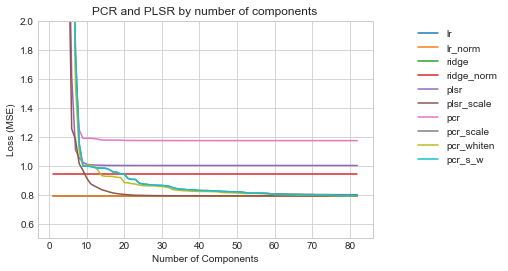

In [14]:
fig, ax = plt.subplots()
ax.set_xlabel("Number of Components")
ax.set_ylabel("Loss (MSE)")
ax.set_title("PCR and PLSR by number of components")

series_labels = scores_df_lr['model'].unique()
for name in series_labels:
    subset = scores_df_lr[scores_df_lr["model"]==name]
    y = [subset["MSE"].tolist()[0] for _ in n_comps]
    x = n_comps
    ax.plot(x,y,label = f"{name}")

series_labels = scores_df_pls['model'].unique()
for name in series_labels:
    subset = scores_df_pls[scores_df_pls["model"]==name]
    ax.plot(subset["n_comp"],subset["MSE"],label = f"{name}")

series_labels = scores_df_pcr['model'].unique()
for name in series_labels:
    subset = scores_df_pcr[scores_df_pcr["model"]==name]
    ax.plot(subset["n_comp"],subset["MSE"],label = f"{name}")

ax.set_ylim(0,max_value)
ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
plt.savefig(log_dir / f"mse_plot.png",bbox_inches='tight')

ax.set_ylim(0.5,2)
#ax.set_ylim(0,5*min_value)
plt.savefig(log_dir / f"mse_plot_compressed.png",bbox_inches='tight')




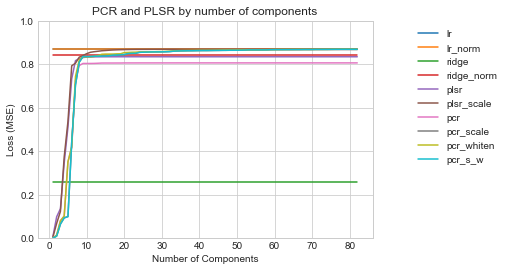

In [15]:
fig, ax = plt.subplots()
ax.set_xlabel("Number of Components")
ax.set_ylabel("Loss (MSE)")
ax.set_title("PCR and PLSR by number of components")

series_labels = scores_df_lr['model'].unique()
for name in series_labels:
    subset = scores_df_lr[scores_df_lr["model"]==name]
    y = [subset["R2"].tolist()[0] for _ in n_comps]
    x = n_comps
    ax.plot(x,y,label = f"{name}")

series_labels = scores_df_pls['model'].unique()
for name in series_labels:
    subset = scores_df_pls[scores_df_pls["model"]==name]
    ax.plot(subset["n_comp"],subset["R2"],label = f"{name}")

series_labels = scores_df_pcr['model'].unique()
for name in series_labels:
    subset = scores_df_pcr[scores_df_pcr["model"]==name]
    ax.plot(subset["n_comp"],subset["R2"],label = f"{name}")

ax.set_ylim(0,1)
ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
plt.savefig(log_dir / f"r2_plot.png",bbox_inches='tight')



